In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


All modules have been imported


# Custom Callback Concept

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In earlier run found invalid image threw error in ImageDataGenerator so we need to not include bad images. In the dataframes. Found the train-ewaste and val-ewaste have jpg image files which are improper file image files. Lets detect these and store the filepaths in a bad_img_list.

In [3]:
train_ewaste_dir=r'../input/waste-segregation-image-dataset/Dataset/train/non_biodegradable/ewaste'
valid_ewaste_dir=r'../input/waste-segregation-image-dataset/Dataset/val/non_biodegradable/ewaste'
bad_img_list=[]
for d in [train_ewaste_dir, valid_ewaste_dir]:
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        try:
            img=plt.imread(fpath)
        except:
            print (fpath)
            bad_img_list.append(fpath)

../input/waste-segregation-image-dataset/Dataset/train/non_biodegradable/ewaste/00000006.jpg
../input/waste-segregation-image-dataset/Dataset/val/non_biodegradable/ewaste/00000261.jpg


# Read in train, test and valid images and create train, test and validation data frames

In [4]:
def make_dataframes(train_dir, val_dir, bad_img_list):
    dirlist=[train_dir,  val_dir]
    names=['train', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        major_classlist=sorted(os.listdir(d) )   #[biodegradable, non_biodegradabl] 
        for major_class in major_classlist:
            major_classpath=os.path.join(d, major_class)           
            class_list=sorted(os.listdir(major_classpath))
            for klass in class_list:
                classpath=os.path.join(major_classpath, klass)
                flist=sorted(os.listdir(classpath))                
                desc=f'{name:5s}-{klass:25s}'            
                for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                    fpath=os.path.join(classpath,f) 
                    if fpath not in bad_img_list: # exclude bad image files from dataframes
                        filepaths.append(fpath)
                        labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if name == 'valid':
            valid_df=df              
        else:
            pdf=df            
    train_df, test_df=train_test_split(pdf, train_size=.9, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'../input/waste-segregation-image-dataset/Dataset/train'
val_dir=r'../input/waste-segregation-image-dataset/Dataset/val'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir,  val_dir, bad_img_list)
    

valid-plastic_bottles          : 100%|███████████████████████████████████████████████████| 130/130 [00:00<00:00, 307534.98files/s]


number of classes in processed dataset=  8
the maximum files in any class in train_df is  9059   the minimum files in any class in train_df is  161
train_df length:  12747   test_df length:  1417   valid_df length:  1200
average image height=  484   average image width=  536  aspect ratio h/w=  0.9029850746268657


# Class Distribution Bar Chart:
**Plot a bar chart showing the distribution of classes in the training dataset.**

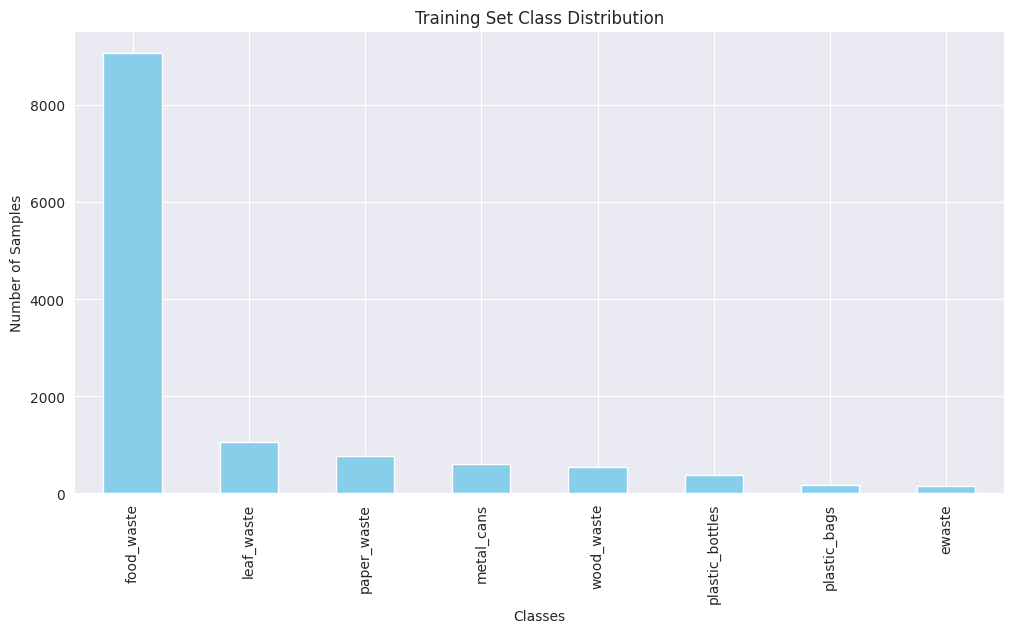

In [5]:
def plot_class_distribution(df, title):
    class_counts = df['labels'].value_counts()
    plt.figure(figsize=(12, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

plot_class_distribution(train_df, 'Training Set Class Distribution')

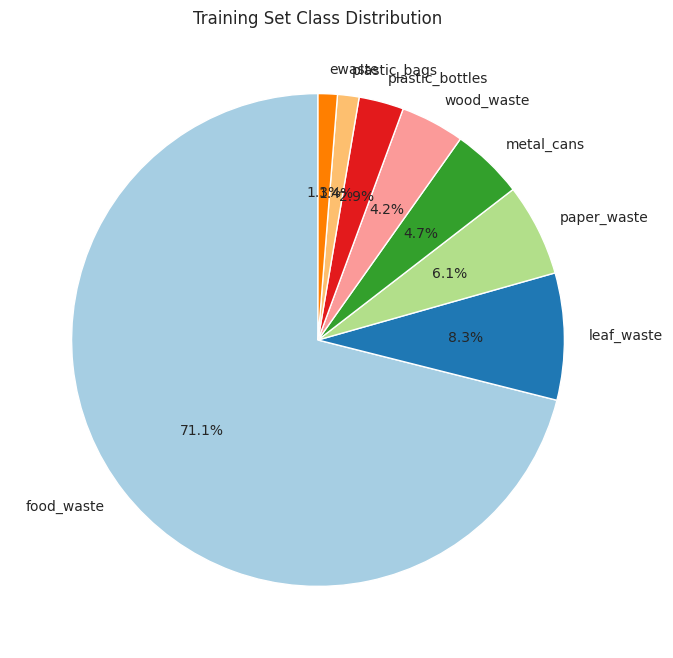

In [6]:
def plot_class_distribution_pie(df, title):
    class_counts = df['labels'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.show()

plot_class_distribution_pie(train_df, 'Training Set Class Distribution')

# Trim train_df so no class has more than max_samples images.

In [7]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=250
min_samples=161
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  12747  with  8  classes
after trimming, the maximum samples in any class is now  250  and the minimum samples in any class is  161
the trimmed dataframe now is of length  1841  with  8  classes


# Image Size Distribution Histogram:
**Plot a histogram showing the distribution of image sizes in the training dataset.**

libpng warning: iCCP: known incorrect sRGB profile


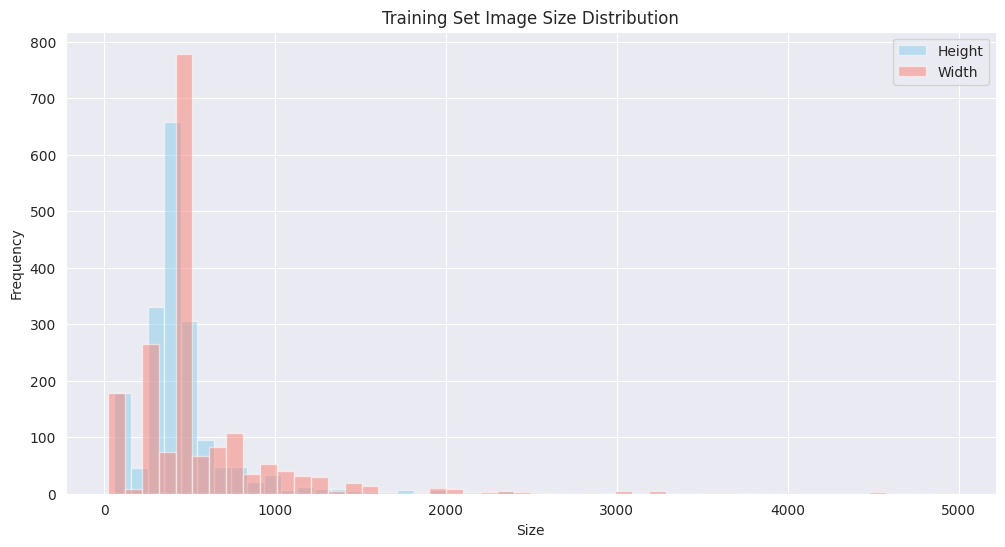

In [8]:
def plot_image_size_distribution(df, title):
    heights = []
    widths = []

    for i in range(len(df)):
        fpath = df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w, _ = img.shape
            heights.append(h)
            widths.append(w)
        except:
            pass

    plt.figure(figsize=(12, 6))
    plt.hist(heights, bins=50, alpha=0.5, label='Height', color='skyblue')
    plt.hist(widths, bins=50, alpha=0.5, label='Width', color='salmon')
    plt.title(title)
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_image_size_distribution(train_df, 'Training Set Image Size Distribution')


# Expand train_df rows with augmented images so each class has 250 samples.

In [9]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=250
working_dir=r'./'
img_size = (200,235)
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  1841
Found 180 validated image filenames.     for class          plastic_bags          creating  70   augmented images 
Found 161 validated image filenames.     for class             ewaste             creating  89   augmented images 
Total Augmented images created=  159
Length of augmented dataframe is now  2000


# Augmentation Impact Bar Chart:
**Compare the number of samples before and after augmentation for each class.**

Initial length of dataframe is  2000
Total Augmented images created=  0
Length of augmented dataframe is now  2000


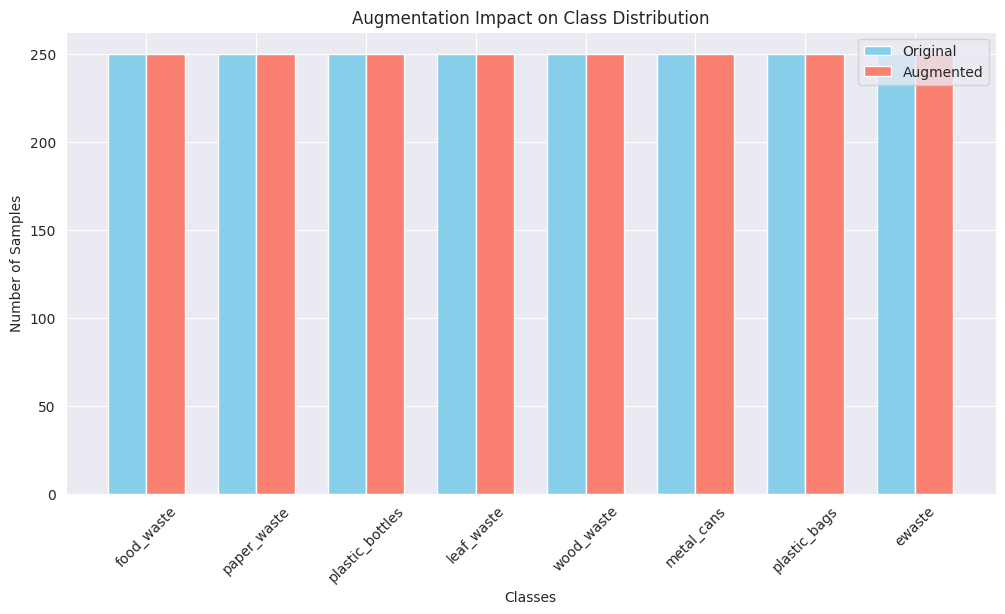

In [10]:
def plot_augmentation_impact(original_df, augmented_df, title):
    original_counts = original_df['labels'].value_counts()
    augmented_counts = augmented_df['labels'].value_counts()

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(original_counts))

    plt.bar(index, original_counts, bar_width, label='Original', color='skyblue')
    plt.bar(index + bar_width, augmented_counts, bar_width, label='Augmented', color='salmon')

    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(index + bar_width / 2, original_counts.index, rotation=45)
    plt.legend()
    plt.show()

augmented_train_df = balance(train_df, n, working_dir, img_size)
plot_augmentation_impact(train_df, augmented_train_df, 'Augmentation Impact on Class Distribution')

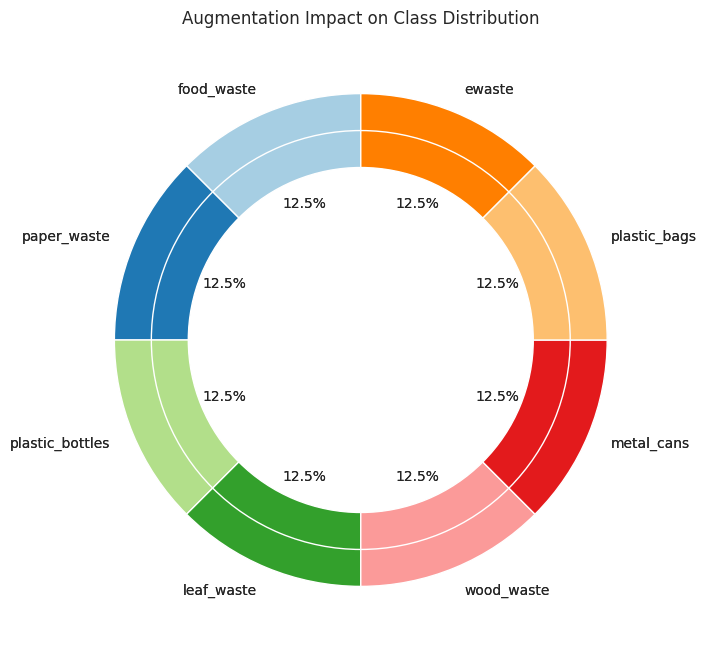

In [11]:
def plot_augmentation_impact_pie(original_df, augmented_df, title):
    original_counts = original_df['labels'].value_counts()
    augmented_counts = augmented_df['labels'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(original_counts, labels=original_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))
    plt.pie(augmented_counts, labels=augmented_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.15))
    plt.title(title)
    plt.show()

plot_augmentation_impact_pie(train_df, augmented_train_df, 'Augmentation Impact on Class Distribution')


# Create the train_gen, test_gen final_test_gen and valid_gen.

In [12]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 1841 validated image filenames belonging to 8 classes.           for train generator 
Found 1200 validated image filenames belonging to 8 classes.           for valid generator 
Found 1417 validated image filenames belonging to 8 classes.           for test generator 
test batch size:  13   test steps:  109  number of classes :  8


Create a function to show example training images.

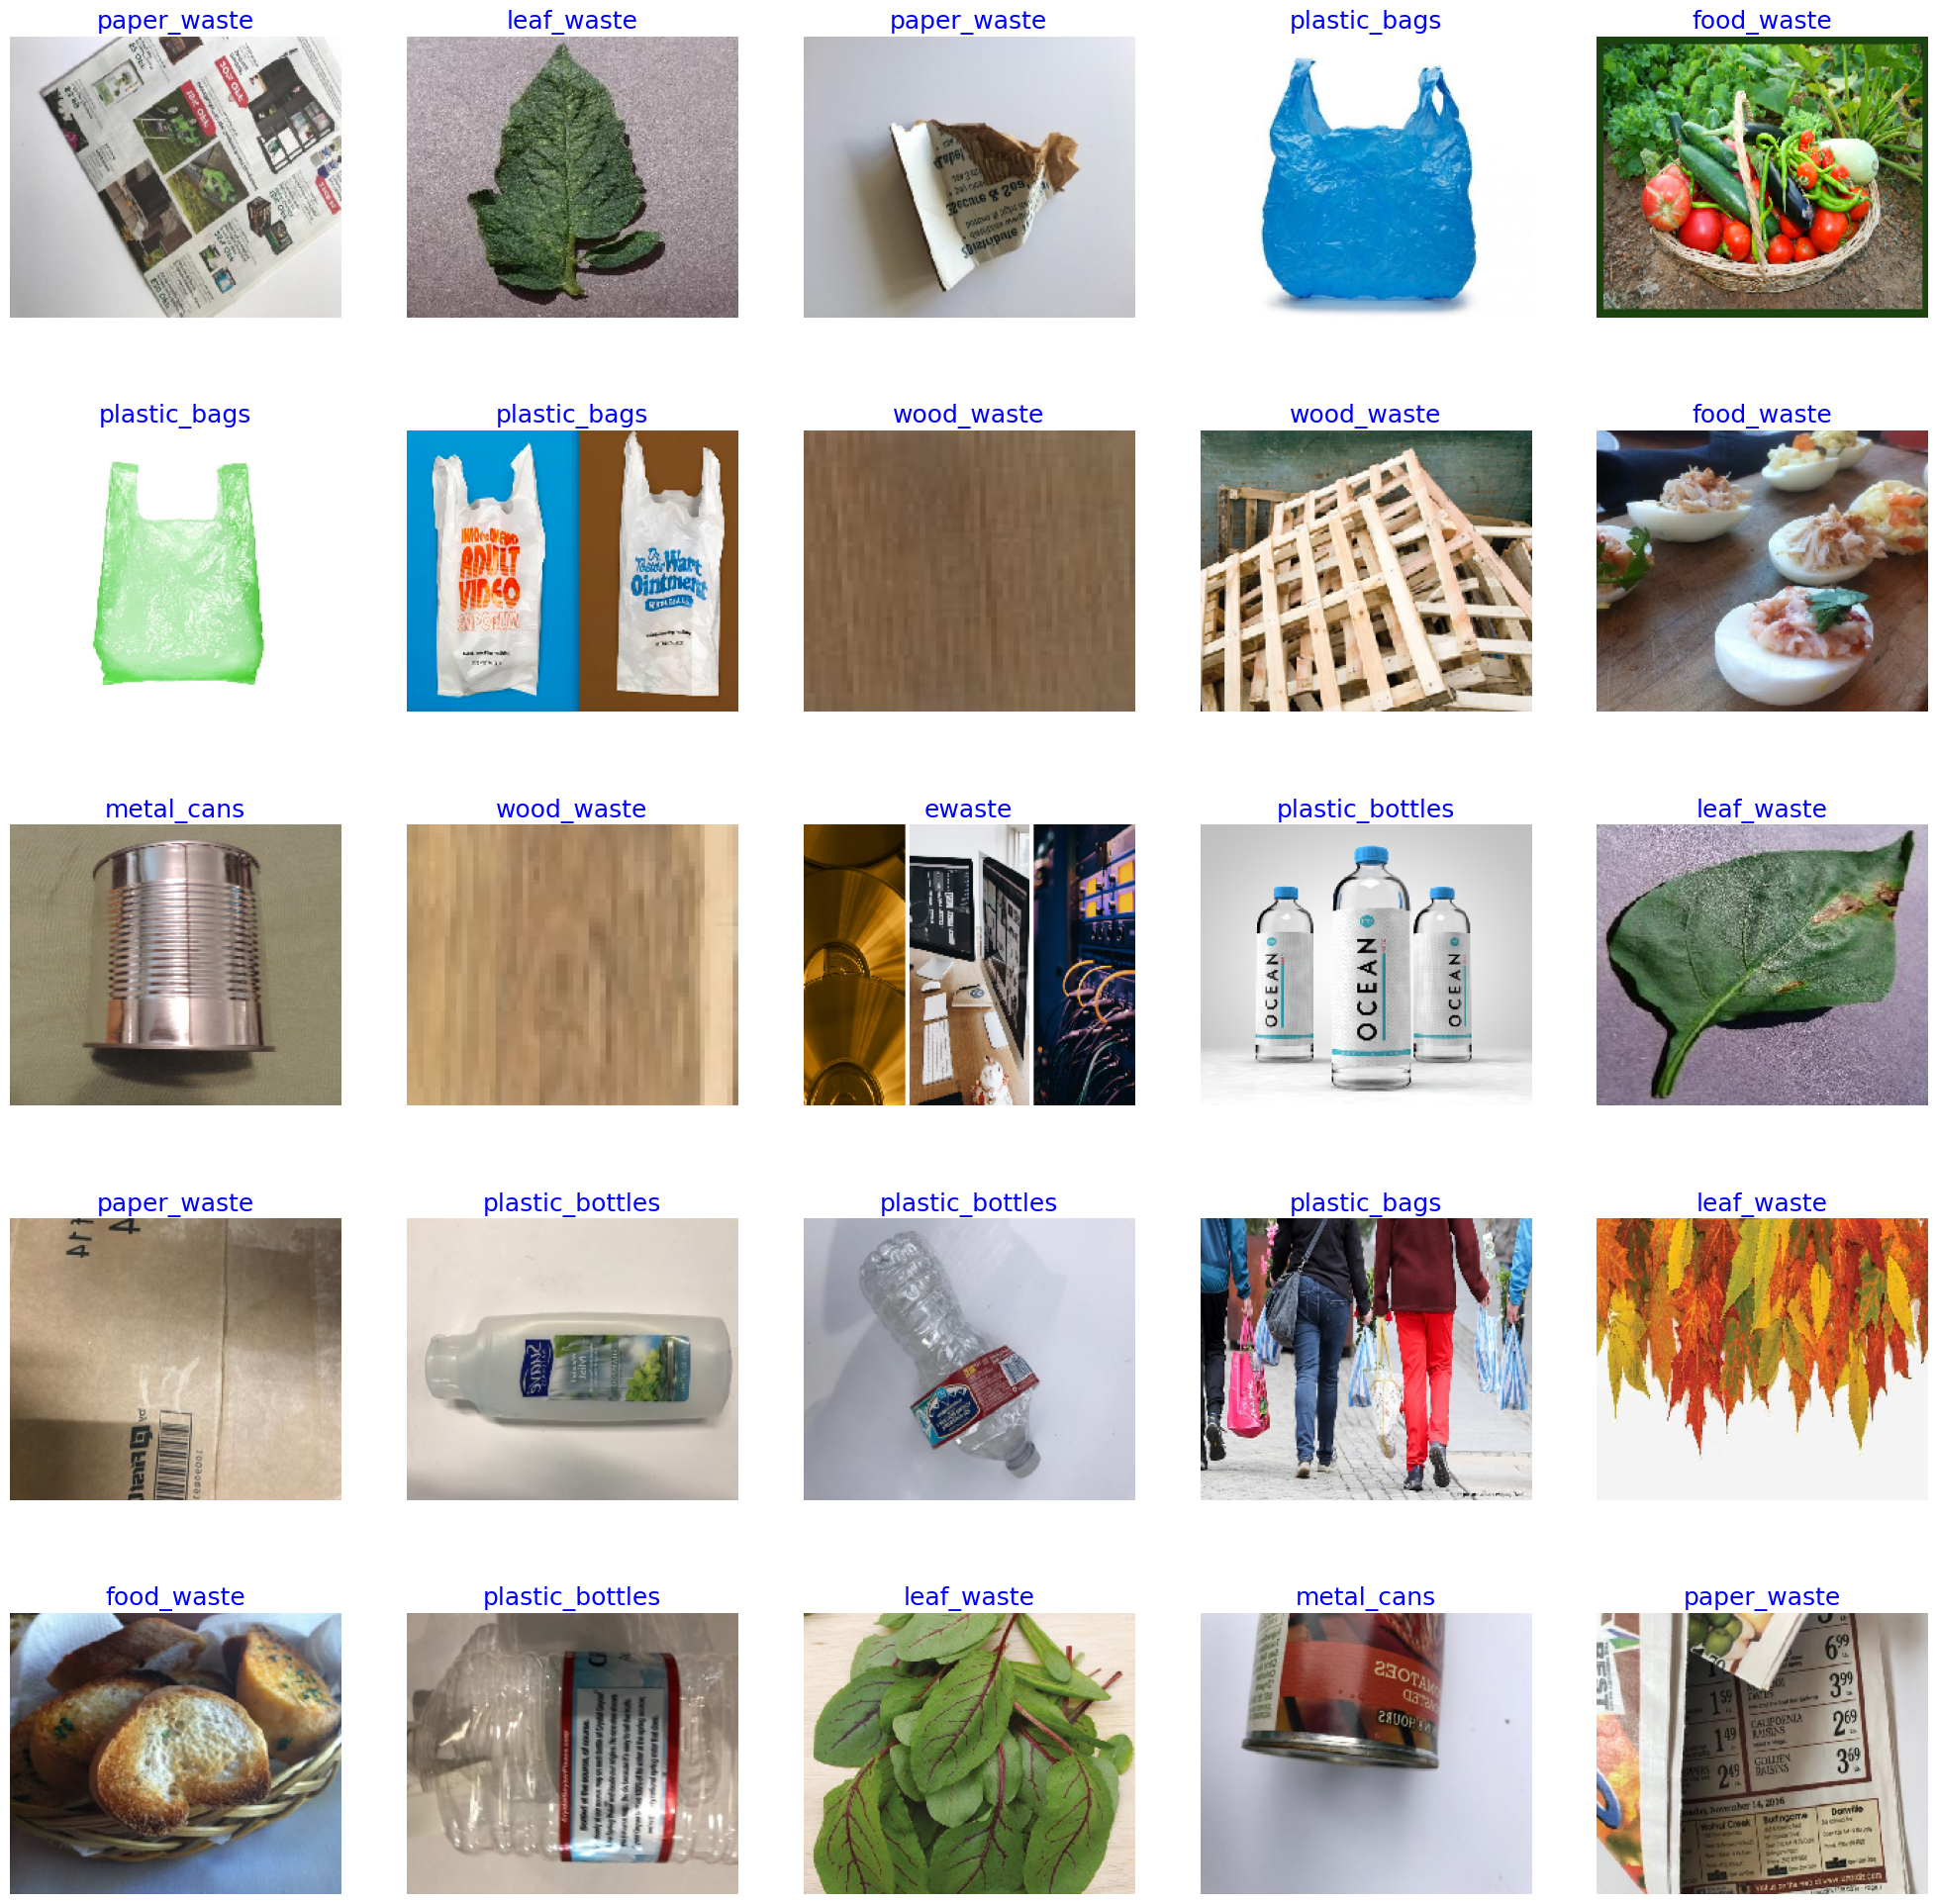

In [13]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

Epoch 1/40
62/62 [==============================] - 61s 447ms/step - loss: 1.4474 - accuracy: 0.6051 - val_loss: 611.3387 - val_accuracy: 0.0400
Epoch 2/40
62/62 [==============================] - 27s 433ms/step - loss: 0.8317 - accuracy: 0.7110 - val_loss: 16.7739 - val_accuracy: 0.0650
Epoch 3/40
62/62 [==============================] - 27s 430ms/step - loss: 0.5417 - accuracy: 0.8153 - val_loss: 10.8138 - val_accuracy: 0.4033
Epoch 4/40
62/62 [==============================] - 27s 435ms/step - loss: 0.4903 - accuracy: 0.8305 - val_loss: 2.6035 - val_accuracy: 0.3942
Epoch 5/40
62/62 [==============================] - 27s 437ms/step - loss: 0.3601 - accuracy: 0.8794 - val_loss: 1.7328 - val_accuracy: 0.6050
Epoch 6/40
62/62 [==============================] - 27s 436ms/step - loss: 0.2567 - accuracy: 0.9174 - val_loss: 1.3230 - val_accuracy: 0.7058
Epoch 7/40
62/62 [==============================] - 27s 439ms/step - loss: 0.2300 - accuracy: 0.9267 - val_loss: 1.7120 - val_accuracy: 0.

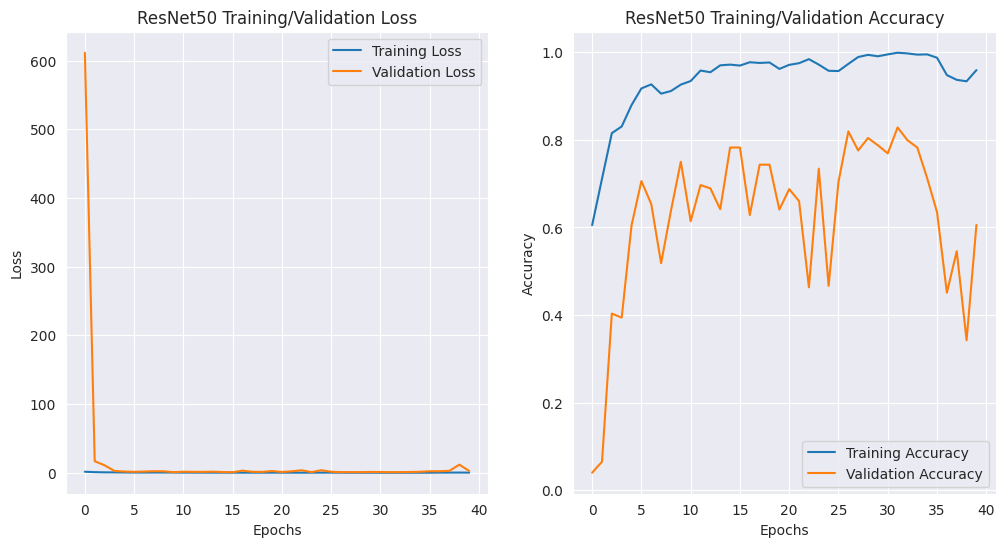

Epoch 1/40
62/62 [==============================] - 34s 487ms/step - loss: 17.7186 - accuracy: 0.1255 - val_loss: 2.0772 - val_accuracy: 0.1092
Epoch 2/40
62/62 [==============================] - 29s 475ms/step - loss: 2.0782 - accuracy: 0.1407 - val_loss: 2.0765 - val_accuracy: 0.0575
Epoch 3/40
62/62 [==============================] - 29s 474ms/step - loss: 2.0761 - accuracy: 0.1309 - val_loss: 2.0730 - val_accuracy: 0.0575
Epoch 4/40
62/62 [==============================] - 30s 491ms/step - loss: 2.0748 - accuracy: 0.1358 - val_loss: 2.0700 - val_accuracy: 0.0575
Epoch 5/40
62/62 [==============================] - 30s 479ms/step - loss: 2.0736 - accuracy: 0.1358 - val_loss: 2.0650 - val_accuracy: 0.0575
Epoch 6/40
62/62 [==============================] - 30s 476ms/step - loss: 2.0725 - accuracy: 0.1249 - val_loss: 2.0618 - val_accuracy: 0.0567
Epoch 7/40
62/62 [==============================] - 30s 478ms/step - loss: 2.0716 - accuracy: 0.1363 - val_loss: 2.0589 - val_accuracy: 0.057

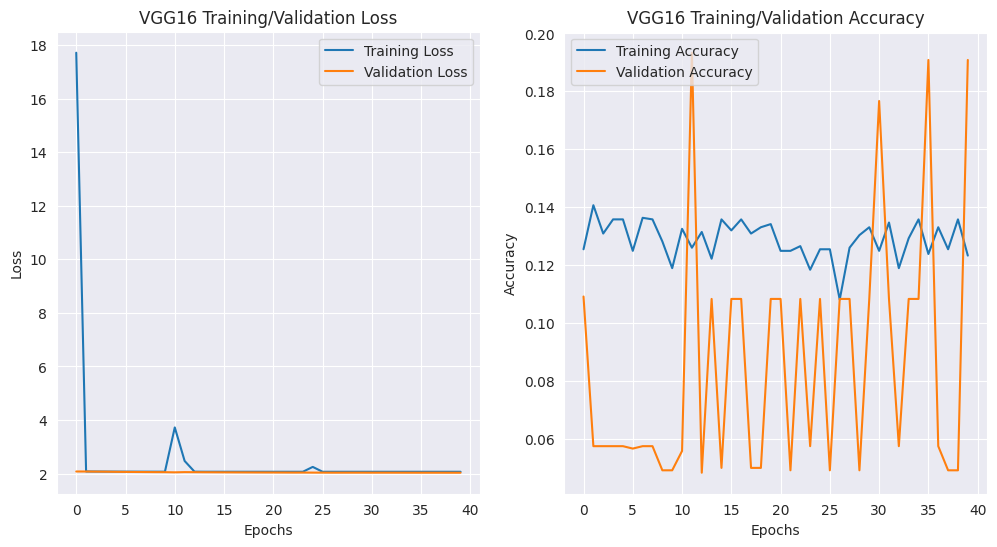

Epoch 1/40


2023-12-04 12:01:44.158177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - 100s 622ms/step - loss: 0.5465 - accuracy: 0.8332 - val_loss: 7.1659 - val_accuracy: 0.5508
Epoch 2/40
62/62 [==============================] - 36s 585ms/step - loss: 0.3004 - accuracy: 0.9147 - val_loss: 0.9788 - val_accuracy: 0.7875
Epoch 3/40
62/62 [==============================] - 36s 580ms/step - loss: 0.1853 - accuracy: 0.9424 - val_loss: 0.7565 - val_accuracy: 0.8533
Epoch 4/40
62/62 [==============================] - 36s 581ms/step - loss: 0.1655 - accuracy: 0.9419 - val_loss: 1.2231 - val_accuracy: 0.8075
Epoch 5/40
62/62 [==============================] - 36s 584ms/step - loss: 0.1962 - accuracy: 0.9430 - val_loss: 3.9229 - val_accuracy: 0.5892
Epoch 6/40
62/62 [==============================] - 36s 581ms/step - loss: 0.1577 - accuracy: 0.9603 - val_loss: 1.1518 - val_accuracy: 0.8033
Epoch 7/40
62/62 [==============================] - 36s 578ms/step - loss: 0.1522 - accuracy: 0.9495 - val_loss: 0.8942 - val_accuracy: 0.8267
Epoch 8/4

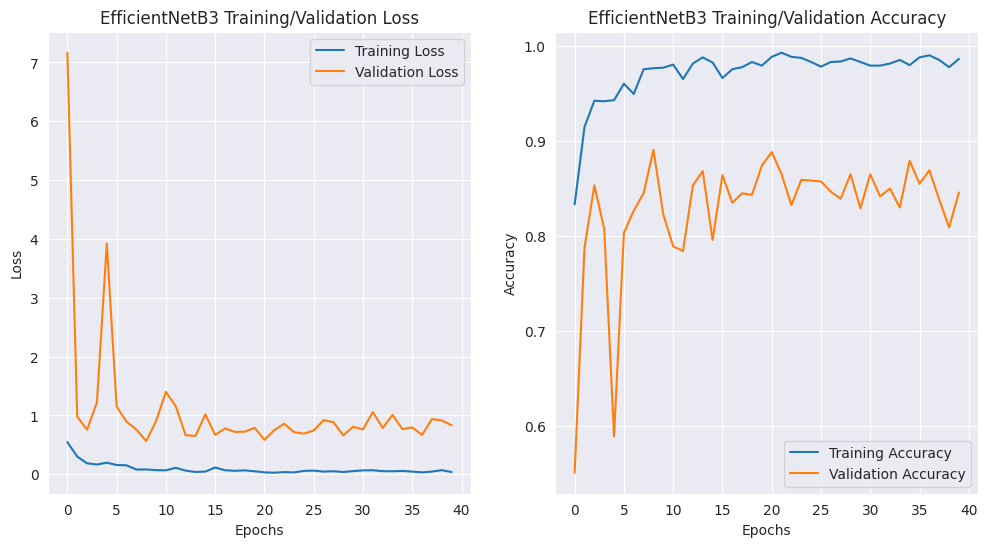

Epoch 1/40
62/62 [==============================] - 19s 275ms/step - loss: 85.2019 - accuracy: 0.2070 - val_loss: 2.0376 - val_accuracy: 0.1275
Epoch 2/40
62/62 [==============================] - 17s 279ms/step - loss: 1.9466 - accuracy: 0.2933 - val_loss: 2.0724 - val_accuracy: 0.1367
Epoch 3/40
62/62 [==============================] - 17s 282ms/step - loss: 1.8832 - accuracy: 0.3237 - val_loss: 1.9934 - val_accuracy: 0.1342
Epoch 4/40
62/62 [==============================] - 17s 279ms/step - loss: 1.7230 - accuracy: 0.3835 - val_loss: 2.0465 - val_accuracy: 0.2125
Epoch 5/40
62/62 [==============================] - 17s 280ms/step - loss: 1.4575 - accuracy: 0.4997 - val_loss: 2.1447 - val_accuracy: 0.2225
Epoch 6/40
62/62 [==============================] - 17s 280ms/step - loss: 1.1976 - accuracy: 0.5948 - val_loss: 2.5511 - val_accuracy: 0.2742
Epoch 7/40
62/62 [==============================] - 17s 278ms/step - loss: 1.0996 - accuracy: 0.6312 - val_loss: 2.5298 - val_accuracy: 0.272

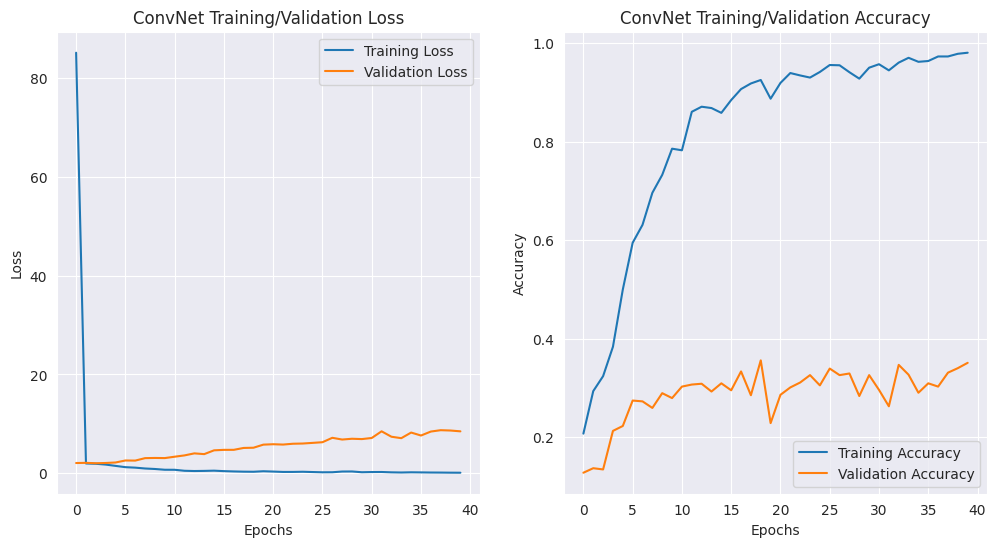

In [33]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

#Function to create and train a model
def create_and_train_model(base_model, train_generator, valid_generator, epochs=40, learning_rate=0.001):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

    return model, history

# Function to plot training/validation loss and accuracy
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training/Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function to create and train ConvNet
def create_and_train_convnet(train_generator, valid_generator, epochs=40, learning_rate=0.001):
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

    return model, history


# Create and train ResNet50
resnet_model, resnet_history = create_and_train_model(ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3)),
                                                      train_gen, valid_gen, epochs=40)
plot_training_history(resnet_history, 'ResNet50')

# Create and train VGG16
vgg16_model, vgg16_history = create_and_train_model(VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3)),
                                                    train_gen, valid_gen, epochs=40)
plot_training_history(vgg16_history, 'VGG16')

# Create and train EfficientNetB3
effnet_model, effnet_history = create_and_train_model(EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3)),
                                                      train_gen, valid_gen, epochs=40)
plot_training_history(effnet_history, 'EfficientNetB3')

# Create and train ConvNet
convnet_model, convnet_history = create_and_train_convnet(train_gen, valid_gen, epochs=40)
plot_training_history(convnet_history, 'ConvNet')


**Create a custom Keras callback to continue and optionally set LR or halt training**

In [46]:
#Version 2
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch, dwell=True, factor=0.4):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1
        self.plist = []
        self.alist = []
        self.dwell = dwell
        self.factor = factor

    def get_list(self):
        return self.plist, self.alist

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            msg = f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg)
            msg = 'enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg = 'learning rate will be automatically adjusted during training'
                print_in_color(msg, (0, 255, 0))
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        msg = f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0, 255, 255))
        self.model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg)

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')
        aloss = logs.get('loss')
        if epoch > 0:
            deltav = self.lowest_vloss - vloss
            pimprov = (deltav / self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa = self.lowest_aloss - aloss
            aimprov = (deltaa / self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov = 0.0
            aimprov = 0.0
        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            # Save only the model's weights (excluding optimizer)
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            msg = f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0, 255, 0))
        else:
            pimprov = abs(pimprov)
            msg = f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255, 255, 0))
            if self.dwell:
                lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = lr * self.factor
                msg = f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                self.model.set_weights(self.best_weights)  # Set only the model's weights

        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss
        if self.ask:
            if epoch + 1 == self.ask_epoch:
                msg = '\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg)
                ans = input()

                if ans == 'H' or ans == 'h' or ans == '0':
                    msg = f'you entered {ans},  Training halted on epoch {epoch + 1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs as ', self.epochs, ' cannot train for ', self.ask_epoch, flush=True)
                    else:
                        msg = f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg)
                        if not self.dwell:
                            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                            msg = f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg)
                            ans = input(' ')
                            if ans == '':
                                msg = f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg)
                            else:
                                new_lr = float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                                msg = f' changing LR to {ans}'
                                print_in_color(msg)


In [47]:
# Function to create and train a model
def create_and_train_model(base_model, train_generator, valid_generator, epochs=10, learning_rate=0.001, callbacks=None):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with the defined callbacks
    history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=callbacks)

    # Get predictions on the validation set
    y_true = valid_generator.classes
    y_pred_probs = model.predict(valid_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history

# Function to create and train ConvNet
def create_and_train_convnet(train_generator, valid_generator, epochs=10, learning_rate=0.001):
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with the defined callback
    history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping])

    # Get predictions on the validation set
    y_true = valid_generator.classes
    y_pred_probs = model.predict(valid_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history

In [53]:
# Define a grid of learning rates and epoch numbers
learning_rates = [0.001, 0.01]
epochs_list = [10, 25, 50]


Training with learning rate for ResNet50: 0.001, epochs: 10
ask_epoch >= epochs, will train for  10  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 1.4581 - accuracy: 0.5997
 validation loss of 1946.8040 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 63s 486ms/step - loss: 1.4581 - accuracy: 0.5997 - val_loss: 1946.8040 - val_accuracy: 0.3175
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.7224
 validation loss of  3.7481 is 99.8075 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 27s 436ms/step - loss: 0.8412 - accuracy: 0.7224 - val_loss: 3.7481 - val_accuracy: 0.3

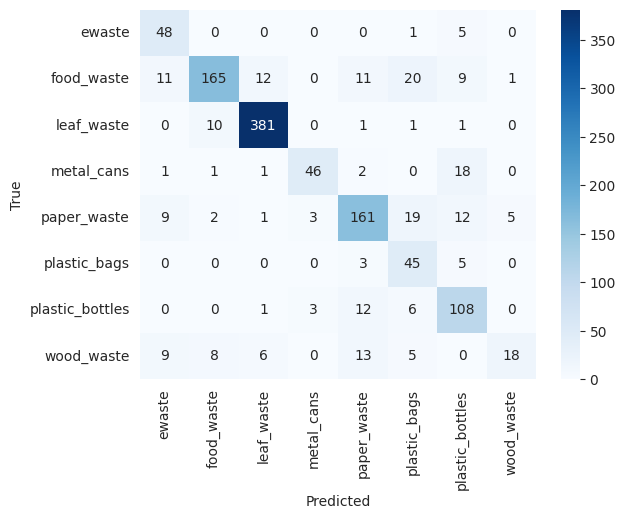

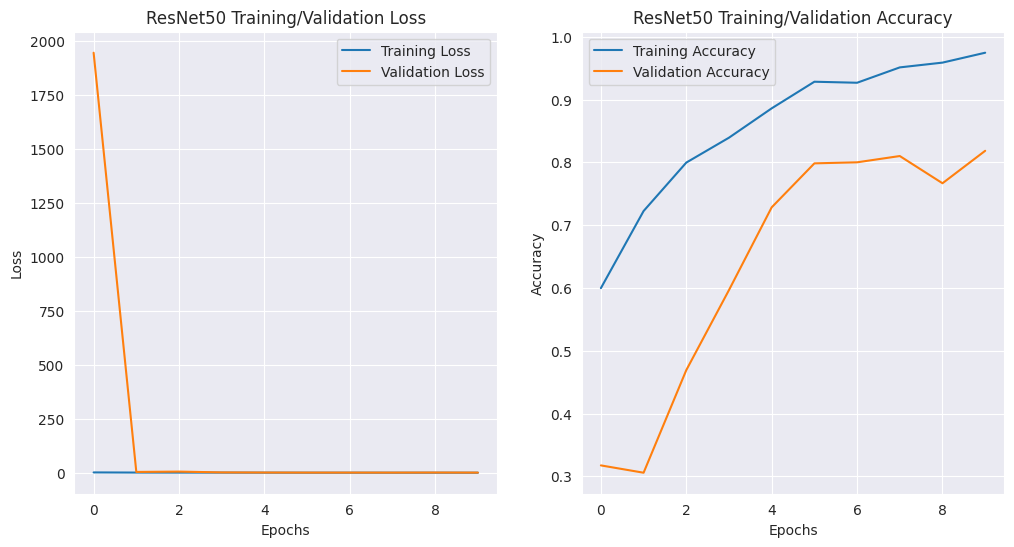


Training with learning rate for ResNet50: 0.001, epochs: 25
ask_epoch >= epochs, will train for  25  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/25
62/62 [==============================] - ETA: 0s - loss: 1.4433 - accuracy: 0.5747
 validation loss of 17.4960 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 61s 456ms/step - loss: 1.4433 - accuracy: 0.5747 - val_loss: 17.4960 - val_accuracy: 0.1100
Epoch 2/25
62/62 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.7262
 validation loss of 18.7954 is  7.4270 % above lowest loss of 17.4960 keeping weights from epoch 1 as best weights

learning rate was automatically adjusted from 0.001000 to 0.000400, model weights set to best weights

62/62 [=============

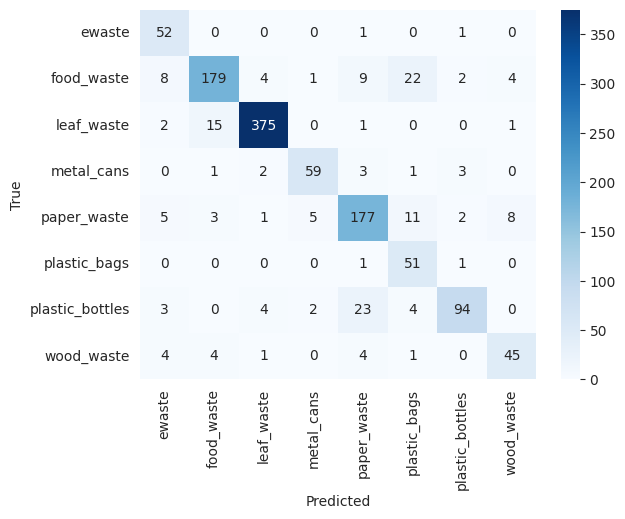

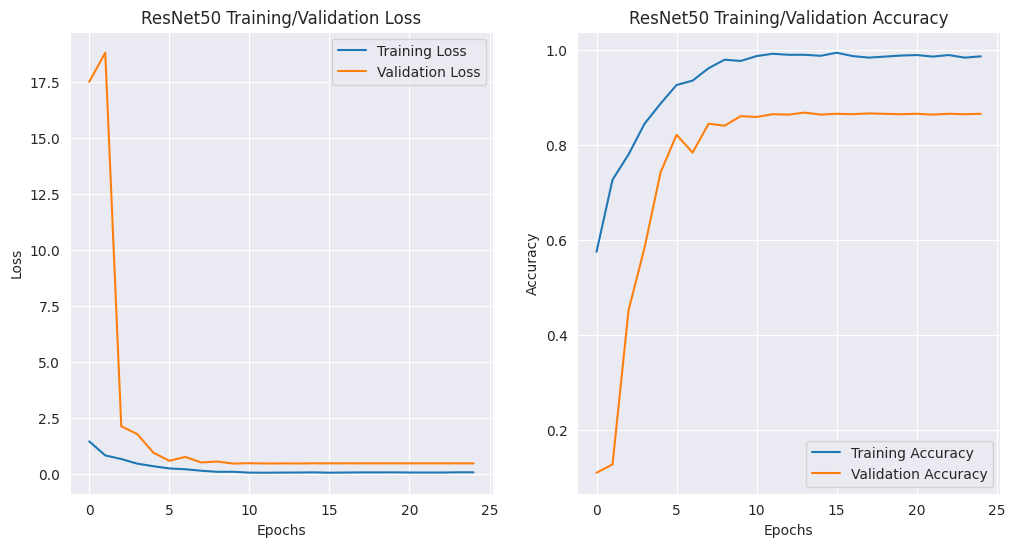


Training with learning rate for ResNet50: 0.001, epochs: 50
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.3321 - accuracy: 0.6274
 validation loss of 36714.8086 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 61s 453ms/step - loss: 1.3321 - accuracy: 0.6274 - val_loss: 36714.8086 - val_accuracy: 0.3283
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.7447
 validation loss of 14.5797 is 99.9603 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 27s 433ms/step - loss: 0.7845 - accuracy: 0.7447 - val_loss: 14.5797 - val_accuracy: 0.2350
Epoch 3/50
62/62 [=======================

 5


you entered 5 Training will continue to epoch 30

62/62 [==============================] - 70s 1s/step - loss: 0.0478 - accuracy: 0.9864 - val_loss: 0.4752 - val_accuracy: 0.8625
Epoch 26/50
62/62 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9891
 validation loss of  0.4738 is  1.5509 % above lowest loss of  0.4666 keeping weights from epoch 13 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 27s 430ms/step - loss: 0.0406 - accuracy: 0.9891 - val_loss: 0.4738 - val_accuracy: 0.8642
Epoch 27/50
62/62 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9891
 validation loss of  0.4747 is  1.7456 % above lowest loss of  0.4666 keeping weights from epoch 13 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 27s 438ms/step - l

 H


you entered H,  Training halted on epoch 30 due to user input


62/62 [==============================] - 31s 500ms/step - loss: 0.0493 - accuracy: 0.9853 - val_loss: 0.4749 - val_accuracy: 0.8625
loading model with weights from epoch 13

training elapsed time was 0.0 hours, 14.0 minutes, 46.92 seconds)

40/40 [==============================] - 9s 193ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.67      0.93      0.78        54
     food_waste       0.92      0.76      0.83       229
     leaf_waste       0.97      0.97      0.97       394
     metal_cans       0.91      0.90      0.91        69
    paper_waste       0.83      0.83      0.83       212
   plastic_bags       0.57      0.94      0.71        53
plastic_bottles       0.87      0.76      0.81       130
     wood_waste       0.74      0.71      0.72        59

       accuracy                           0.86      1200
      macro avg       0.81      0.85      0.8

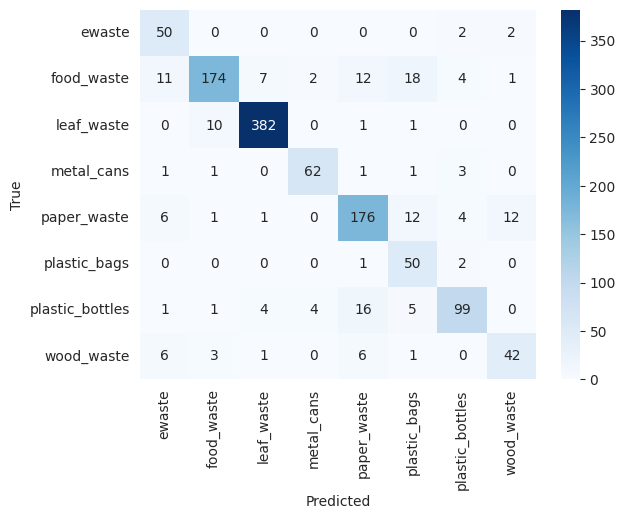

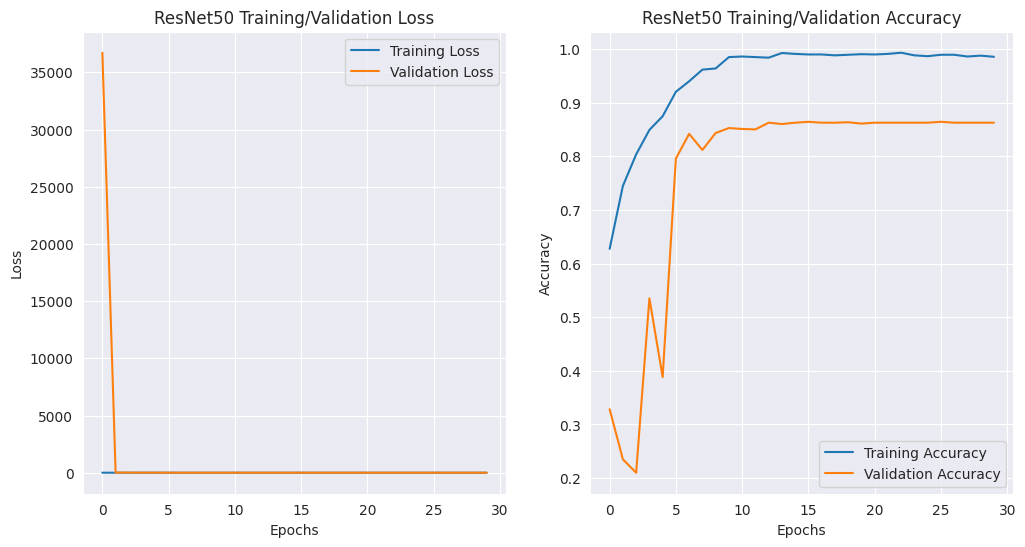


Training with learning rate for ResNet50: 0.01, epochs: 10
ask_epoch >= epochs, will train for  10  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 3.7457 - accuracy: 0.1651
 validation loss of 1966867584.0000 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 64s 447ms/step - loss: 3.7457 - accuracy: 0.1651 - val_loss: 1966867584.0000 - val_accuracy: 0.1767
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 2.3135 - accuracy: 0.2667
 validation loss of 39592.8984 is 99.9980 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 28s 444ms/step - loss: 2.3135 - accuracy: 0.2667 - val_loss: 39592.8984 -

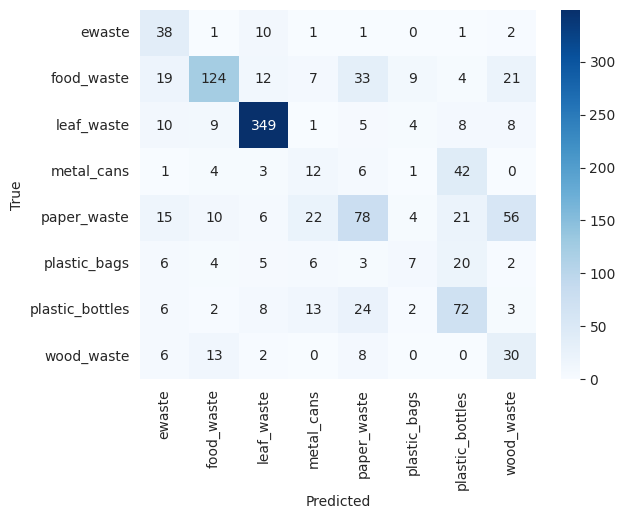

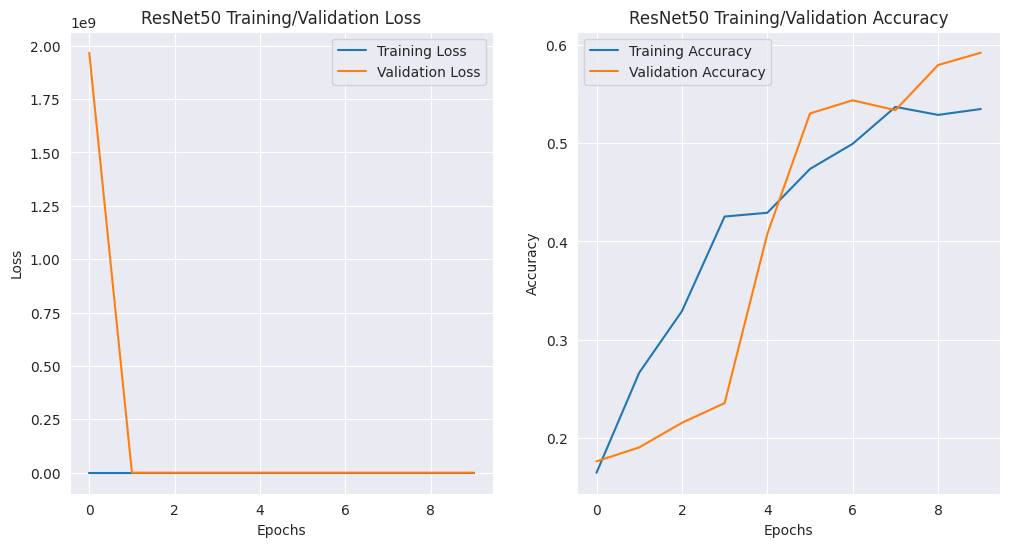


Training with learning rate for ResNet50: 0.01, epochs: 25
ask_epoch >= epochs, will train for  25  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/25
62/62 [==============================] - ETA: 0s - loss: 3.2994 - accuracy: 0.2683
 validation loss of 118772318208.0000 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 61s 448ms/step - loss: 3.2994 - accuracy: 0.2683 - val_loss: 118772318208.0000 - val_accuracy: 0.0400
Epoch 2/25
62/62 [==============================] - ETA: 0s - loss: 2.0609 - accuracy: 0.3449
 validation loss of 40007.5898 is 100.0000 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 27s 428ms/step - loss: 2.0609 - accuracy: 0.3449 - val_loss: 40007.5

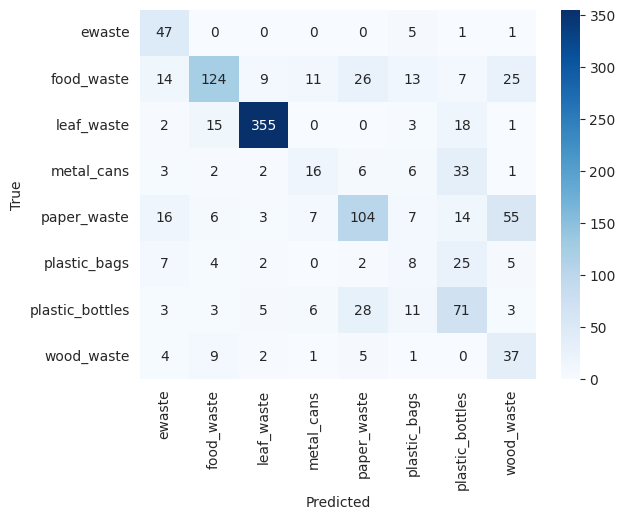

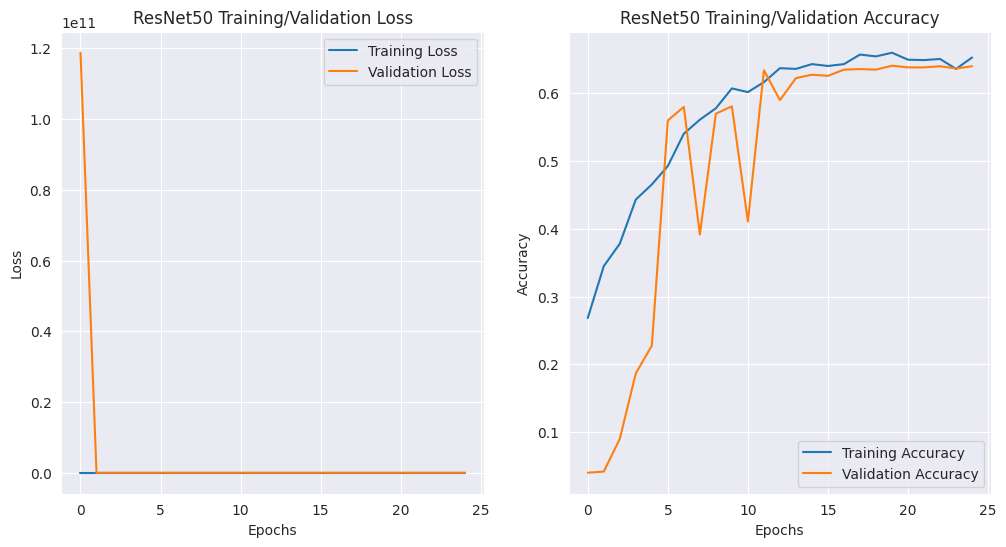


Training with learning rate for ResNet50: 0.01, epochs: 50
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 2.8333 - accuracy: 0.3140
 validation loss of 11180078080.0000 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 61s 450ms/step - loss: 2.8333 - accuracy: 0.3140 - val_loss: 11180078080.0000 - val_accuracy: 0.0575
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 2.8648 - accuracy: 0.2645
 validation loss of 38821.3320 is 99.9997 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 27s 437ms/step - loss: 2.8648 - accuracy: 0.2645 - val_loss: 38821.3320 - val_accuracy: 0.1767
Epoch 3/50
62/62 [======

 10


you entered 10 Training will continue to epoch 35

62/62 [==============================] - 100s 2s/step - loss: 0.9436 - accuracy: 0.6534 - val_loss: 0.9731 - val_accuracy: 0.6617
Epoch 26/50
62/62 [==============================] - ETA: 0s - loss: 0.9545 - accuracy: 0.6507
 validation loss of  0.9722 is  0.4357 % above lowest loss of  0.9680 keeping weights from epoch 14 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 27s 429ms/step - loss: 0.9545 - accuracy: 0.6507 - val_loss: 0.9722 - val_accuracy: 0.6617
Epoch 27/50
62/62 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6448
 validation loss of  0.9676 is  0.0394 % below lowest loss, saving weights from epoch 27  as best weights

62/62 [==============================] - 27s 441ms/step - loss: 0.9607 - accuracy: 0.6448 - val_loss: 0.9676 - val_accuracy: 0.6650
Epoch 28/50
62/62 [===================

 H


you entered H,  Training halted on epoch 35 due to user input


62/62 [==============================] - 59s 968ms/step - loss: 0.9593 - accuracy: 0.6534 - val_loss: 0.9729 - val_accuracy: 0.6633
loading model with weights from epoch 27

training elapsed time was 0.0 hours, 18.0 minutes, 31.60 seconds)

40/40 [==============================] - 9s 201ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.52      0.93      0.67        54
     food_waste       0.75      0.68      0.71       229
     leaf_waste       0.98      0.91      0.94       394
     metal_cans       0.37      0.49      0.42        69
    paper_waste       0.63      0.40      0.49       212
   plastic_bags       0.28      0.49      0.36        53
plastic_bottles       0.50      0.46      0.48       130
     wood_waste       0.31      0.47      0.38        59

       accuracy                           0.67      1200
      macro avg       0.54      0.60      0.5

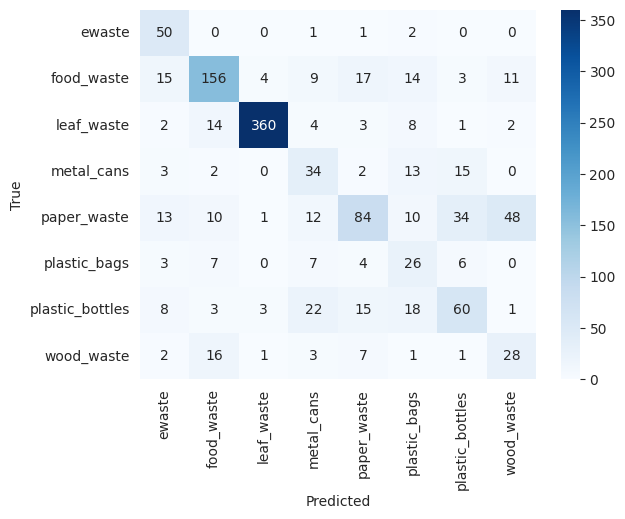

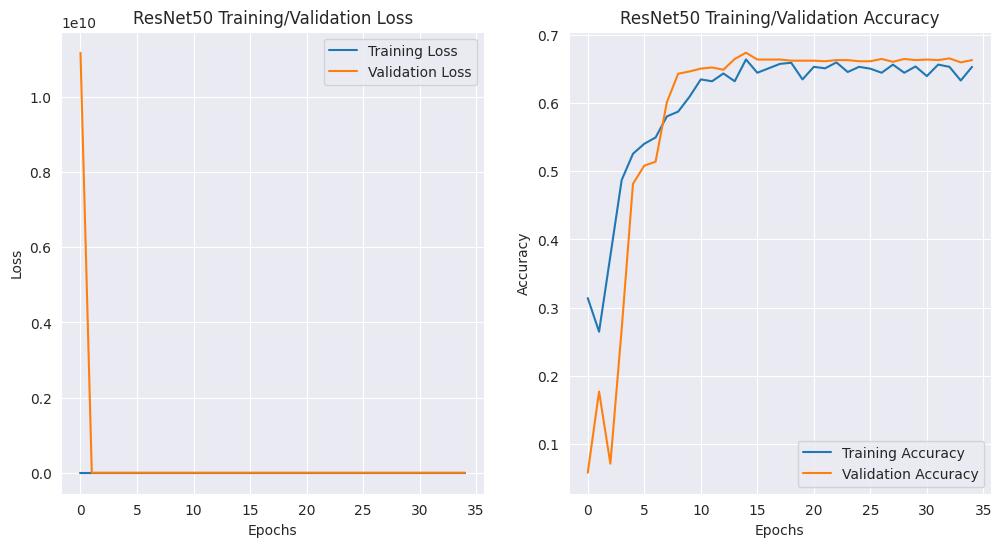

In [54]:
from itertools import product
# Iterate over all combinations
for learning_rate, epochs in product(learning_rates, epochs_list):
    print(f"\nTraining with learning rate for ResNet50: {learning_rate}, epochs: {epochs}\n{'='*50}")

    # Create LR_ASK callback
    ask_epoch = 25  
    ask = LR_ASK(model, epochs, ask_epoch)
    callbacks = [ask]

    # Create and train ResNet50
    resnet_model, resnet_history = create_and_train_model(ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3)),
                                                          train_gen, valid_gen, epochs=epochs, learning_rate=learning_rate, callbacks=callbacks)
    # Plot training/validation loss and accuracy
    plot_training_history(resnet_history, 'ResNet50')

In [55]:
# Define a grid of learning rates and epoch numbers
learning_rates = [0.001, 0.0001]
epochs_list = [25, 50, 100]


Training with learning rate for EfficientNetB3: 0.001, epochs: 25
ask_epoch >= epochs, will train for  25  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/25


2023-12-04 15:30:05.847757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.8289
 validation loss of  4.1799 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 102s 635ms/step - loss: 0.5824 - accuracy: 0.8289 - val_loss: 4.1799 - val_accuracy: 0.7042
Epoch 2/25
62/62 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.9180
 validation loss of  0.8765 is 79.0312 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 37s 585ms/step - loss: 0.3078 - accuracy: 0.9180 - val_loss: 0.8765 - val_accuracy: 0.7875
Epoch 3/25
62/62 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9332
 validation loss of  0.9429 is  7.5743 % above lowest loss of  0.8765 keeping weights from epoch 2 as best weights

learning rate was automatically adjusted from 0.001000 to 0.000400, model weights set to best weights

62/62 [========================

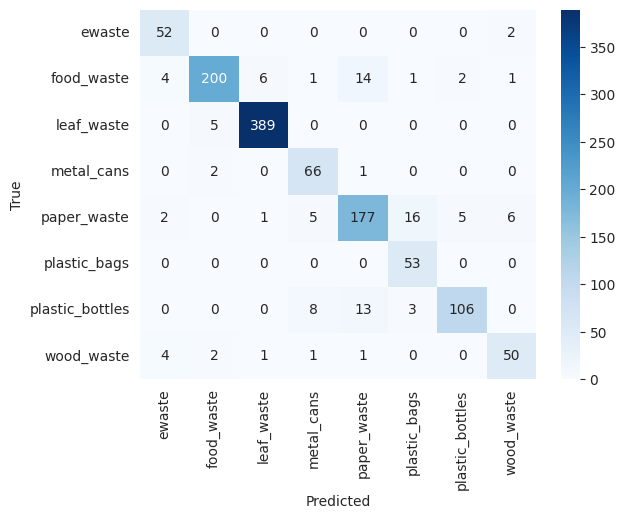

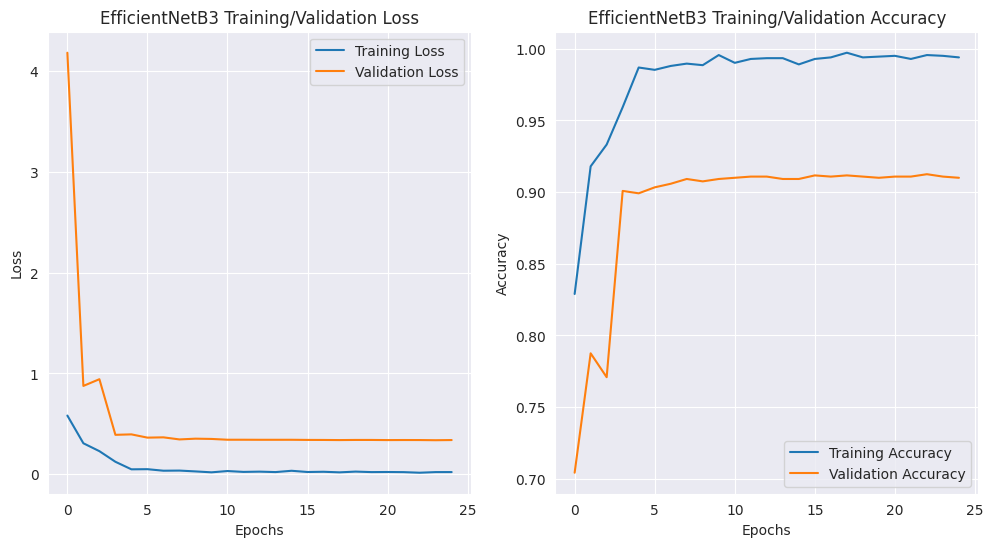


Training with learning rate for EfficientNetB3: 0.001, epochs: 50
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50


2023-12-04 15:46:38.990198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_27/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.8186
 validation loss of  0.9482 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 99s 626ms/step - loss: 0.5736 - accuracy: 0.8186 - val_loss: 0.9482 - val_accuracy: 0.8000
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9136
 validation loss of  0.8163 is 13.9100 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 36s 582ms/step - loss: 0.2620 - accuracy: 0.9136 - val_loss: 0.8163 - val_accuracy: 0.8033
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9446
 validation loss of  0.8922 is  9.3002 % above lowest loss of  0.8163 keeping weights from epoch 2 as best weights

learning rate was automatically adjusted from 0.001000 to 0.000400, model weights set to best weights

62/62 [=========================

 10


you entered 10 Training will continue to epoch 35

62/62 [==============================] - 432s 7s/step - loss: 0.0183 - accuracy: 0.9962 - val_loss: 0.3411 - val_accuracy: 0.9183
Epoch 26/50
62/62 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9951
 validation loss of  0.3407 is  0.3440 % above lowest loss of  0.3396 keeping weights from epoch 18 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 37s 592ms/step - loss: 0.0198 - accuracy: 0.9951 - val_loss: 0.3407 - val_accuracy: 0.9183
Epoch 27/50
62/62 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9957
 validation loss of  0.3419 is  0.6813 % above lowest loss of  0.3396 keeping weights from epoch 18 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 36s 587ms/step -

 H


you entered H,  Training halted on epoch 35 due to user input


62/62 [==============================] - 69s 1s/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.3392 - val_accuracy: 0.9183
loading model with weights from epoch 31

training elapsed time was 0.0 hours, 29.0 minutes, 26.23 seconds)

40/40 [==============================] - 10s 194ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.79      0.96      0.87        54
     food_waste       0.97      0.88      0.92       229
     leaf_waste       0.98      0.98      0.98       394
     metal_cans       0.80      0.96      0.87        69
    paper_waste       0.92      0.87      0.90       212
   plastic_bags       0.82      1.00      0.90        53
plastic_bottles       0.95      0.81      0.87       130
     wood_waste       0.71      0.93      0.81        59

       accuracy                           0.92      1200
      macro avg       0.87      0.92      0.89 

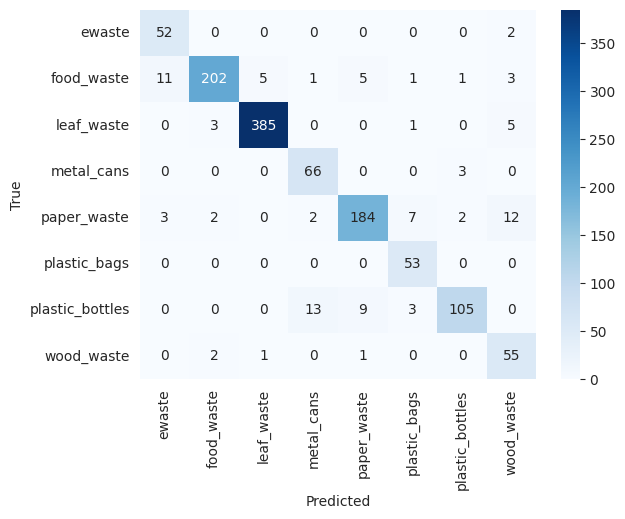

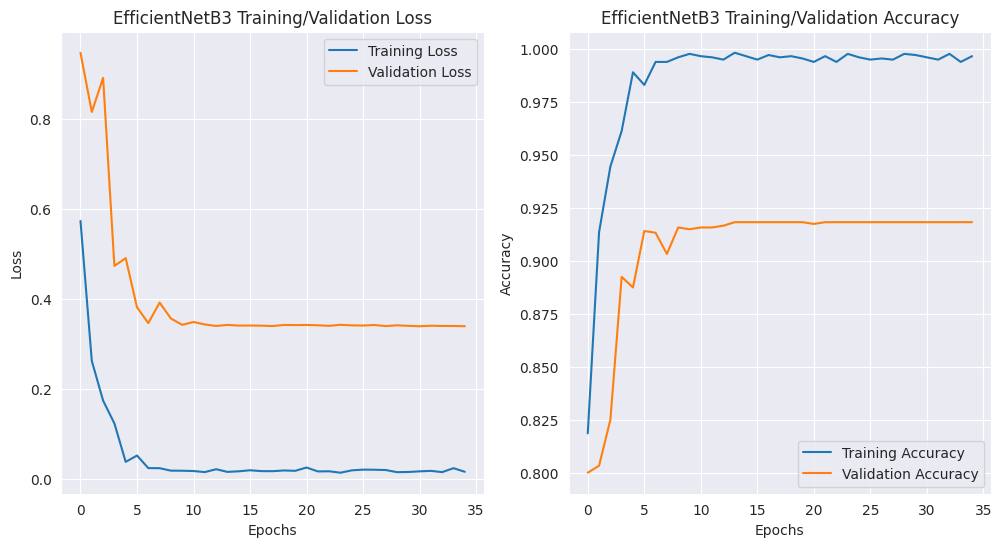


Training with learning rate for EfficientNetB3: 0.001, epochs: 100
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/100


2023-12-04 16:16:20.594293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.8256
 validation loss of  1.4228 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 98s 635ms/step - loss: 0.5634 - accuracy: 0.8256 - val_loss: 1.4228 - val_accuracy: 0.7333
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.9125
 validation loss of  1.3346 is  6.2001 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 37s 587ms/step - loss: 0.2634 - accuracy: 0.9125 - val_loss: 1.3346 - val_accuracy: 0.7967
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9299
 validation loss of  0.8661 is 35.1039 % below lowest loss, saving weights from epoch 3   as best weights

62/62 [==============================] - 36s 586ms/step - loss: 0.2284 - accuracy: 0.9299 - val_loss: 0.8661 - val_accuracy: 0.8417
Epoch 4/10

 25


you entered 25 Training will continue to epoch 50

62/62 [==============================] - 45s 722ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.4010 - val_accuracy: 0.9092
Epoch 26/100
62/62 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9978
 validation loss of  0.3984 is  0.0355 % above lowest loss of  0.3983 keeping weights from epoch 16 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 36s 585ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.3984 - val_accuracy: 0.9092
Epoch 27/100
62/62 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978
 validation loss of  0.3997 is  0.3579 % above lowest loss of  0.3983 keeping weights from epoch 16 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 36s 586ms/st

 H


you entered H,  Training halted on epoch 50 due to user input


62/62 [==============================] - 339s 6s/step - loss: 0.0079 - accuracy: 0.9989 - val_loss: 0.3984 - val_accuracy: 0.9092
loading model with weights from epoch 37

training elapsed time was 0.0 hours, 36.0 minutes, 31.12 seconds)

40/40 [==============================] - 10s 191ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.86      0.94      0.90        54
     food_waste       0.94      0.89      0.91       229
     leaf_waste       0.98      0.98      0.98       394
     metal_cans       0.76      0.96      0.85        69
    paper_waste       0.90      0.85      0.87       212
   plastic_bags       0.69      0.98      0.81        53
plastic_bottles       0.94      0.78      0.85       130
     wood_waste       0.84      0.86      0.85        59

       accuracy                           0.91      1200
      macro avg       0.86      0.91      0.88

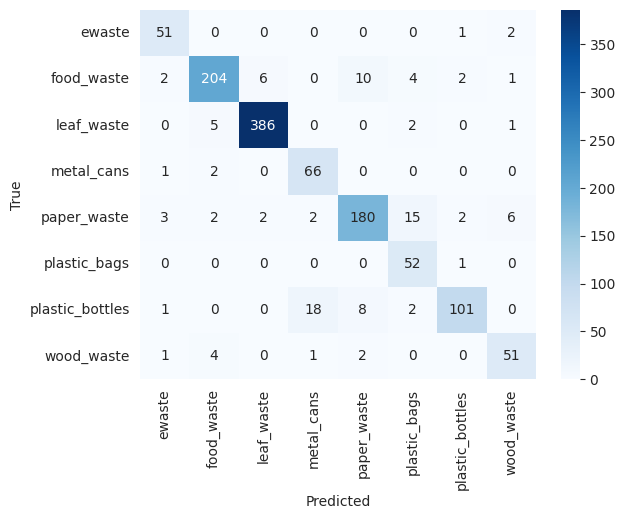

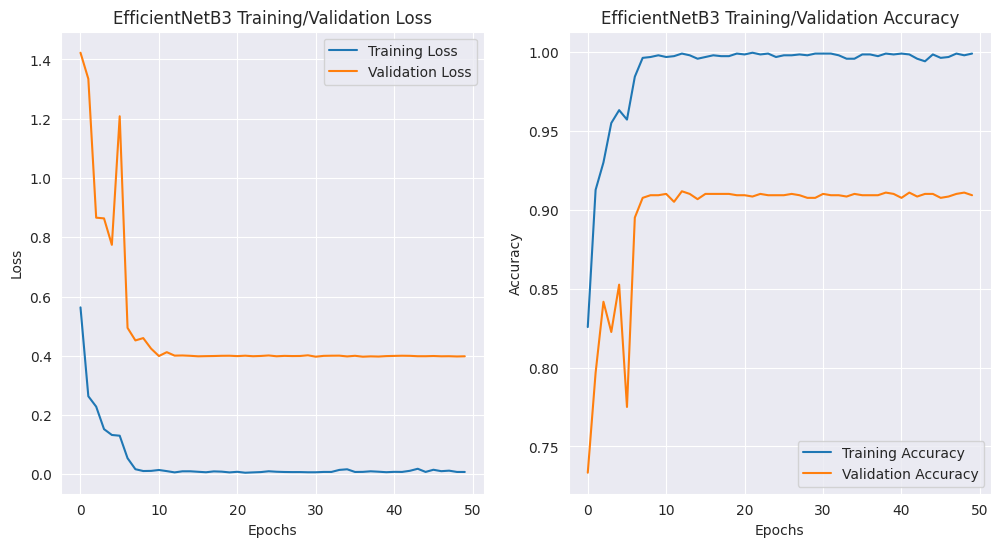


Training with learning rate for EfficientNetB3: 0.0001, epochs: 25
ask_epoch >= epochs, will train for  25  epochs
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/25


2023-12-04 16:53:12.503710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.7442
 validation loss of  0.4689 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 103s 619ms/step - loss: 0.9745 - accuracy: 0.7442 - val_loss: 0.4689 - val_accuracy: 0.8700
Epoch 2/25
62/62 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9321
 validation loss of  0.3180 is 32.1835 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 36s 570ms/step - loss: 0.2596 - accuracy: 0.9321 - val_loss: 0.3180 - val_accuracy: 0.9075
Epoch 3/25
62/62 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9723
 validation loss of  0.2767 is 12.9803 % below lowest loss, saving weights from epoch 3   as best weights

62/62 [==============================] - 36s 575ms/step - loss: 0.1196 - accuracy: 0.9723 - val_loss: 0.2767 - val_accuracy: 0.9217
Epoch 4/25


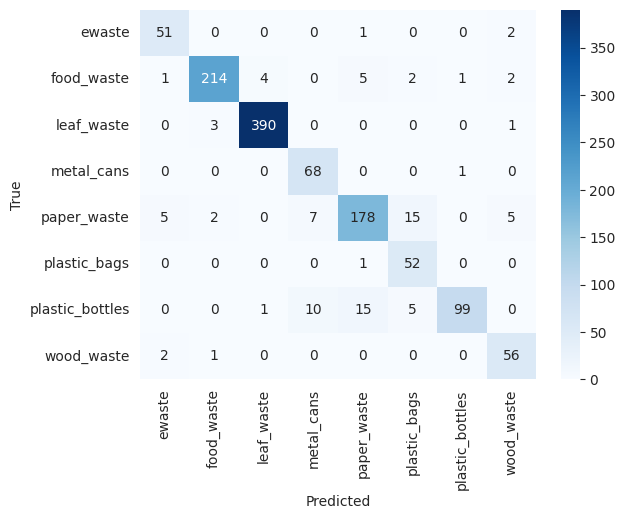

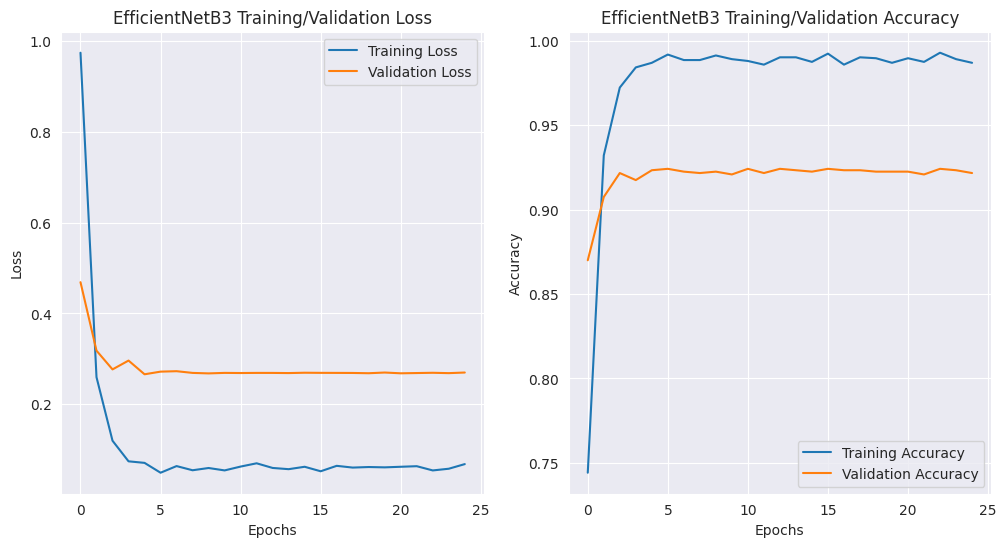


Training with learning rate for EfficientNetB3: 0.0001, epochs: 50
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50


2023-12-04 17:09:38.745260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 0.9874 - accuracy: 0.7311
 validation loss of  0.4447 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 101s 662ms/step - loss: 0.9874 - accuracy: 0.7311 - val_loss: 0.4447 - val_accuracy: 0.8783
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9511
 validation loss of  0.3040 is 31.6476 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 36s 582ms/step - loss: 0.2390 - accuracy: 0.9511 - val_loss: 0.3040 - val_accuracy: 0.9075
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9750
 validation loss of  0.2681 is 11.8191 % below lowest loss, saving weights from epoch 3   as best weights

62/62 [==============================] - 36s 578ms/step - loss: 0.1048 - accuracy: 0.9750 - val_loss: 0.2681 - val_accuracy: 0.9200
Epoch 4/50


 15


you entered 15 Training will continue to epoch 40

62/62 [==============================] - 461s 8s/step - loss: 0.0680 - accuracy: 0.9891 - val_loss: 0.2787 - val_accuracy: 0.9175
Epoch 26/50
62/62 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9859
 validation loss of  0.2788 is  4.0055 % above lowest loss of  0.2681 keeping weights from epoch 3 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 37s 598ms/step - loss: 0.0700 - accuracy: 0.9859 - val_loss: 0.2788 - val_accuracy: 0.9167
Epoch 27/50
62/62 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9902
 validation loss of  0.2786 is  3.9359 % above lowest loss of  0.2681 keeping weights from epoch 3 as best weights

learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights

62/62 [==============================] - 36s 584ms/step - l

 H


you entered H,  Training halted on epoch 40 due to user input


62/62 [==============================] - 76s 1s/step - loss: 0.0740 - accuracy: 0.9853 - val_loss: 0.2779 - val_accuracy: 0.9167
loading model with weights from epoch 3

training elapsed time was 0.0 hours, 32.0 minutes, 59.66 seconds)

40/40 [==============================] - 10s 190ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.84      0.94      0.89        54
     food_waste       0.98      0.93      0.95       229
     leaf_waste       0.99      0.99      0.99       394
     metal_cans       0.81      0.97      0.88        69
    paper_waste       0.89      0.84      0.86       212
   plastic_bags       0.74      0.98      0.85        53
plastic_bottles       0.92      0.75      0.83       130
     wood_waste       0.81      0.92      0.86        59

       accuracy                           0.92      1200
      macro avg       0.87      0.92      0.89  

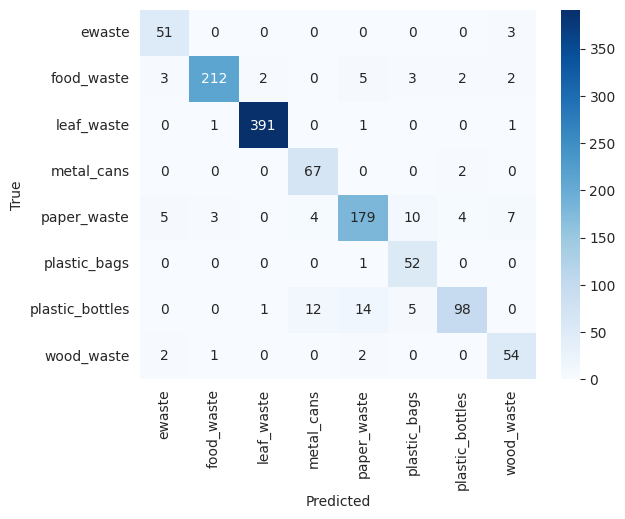

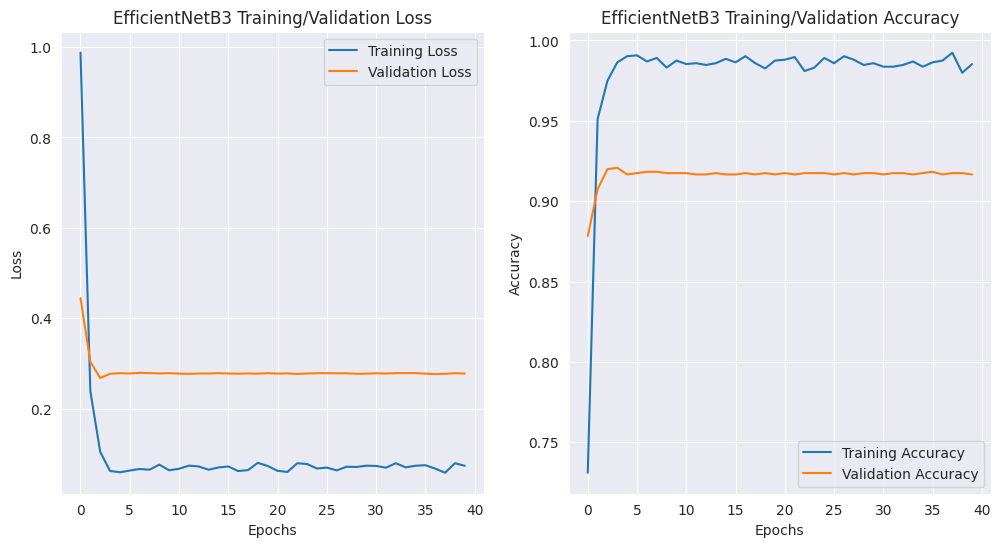


Training with learning rate for EfficientNetB3: 0.0001, epochs: 100
Training will proceed until epoch 25 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/100


2023-12-04 17:42:55.213917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_31/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 1.0099 - accuracy: 0.7295
 validation loss of  0.4422 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 98s 629ms/step - loss: 1.0099 - accuracy: 0.7295 - val_loss: 0.4422 - val_accuracy: 0.8858
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9402
 validation loss of  0.3240 is 26.7309 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 36s 587ms/step - loss: 0.2497 - accuracy: 0.9402 - val_loss: 0.3240 - val_accuracy: 0.9142
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9788
 validation loss of  0.3033 is  6.3895 % below lowest loss, saving weights from epoch 3   as best weights

62/62 [==============================] - 36s 581ms/step - loss: 0.1156 - accuracy: 0.9788 - val_loss: 0.3033 - val_accuracy: 0.9267
Epoch 4/10

 H


you entered H,  Training halted on epoch 25 due to user input


62/62 [==============================] - 46s 750ms/step - loss: 0.0433 - accuracy: 0.9880 - val_loss: 0.2763 - val_accuracy: 0.9225
loading model with weights from epoch 5

training elapsed time was 0.0 hours, 16.0 minutes, 18.97 seconds)

40/40 [==============================] - 10s 188ms/step
Classification Report:
                 precision    recall  f1-score   support

         ewaste       0.91      0.91      0.91        54
     food_waste       0.96      0.95      0.95       229
     leaf_waste       0.99      0.98      0.99       394
     metal_cans       0.78      0.97      0.86        69
    paper_waste       0.89      0.86      0.87       212
   plastic_bags       0.71      0.98      0.83        53
plastic_bottles       0.96      0.77      0.85       130
     wood_waste       0.88      0.88      0.88        59

       accuracy                           0.92      1200
      macro avg       0.88      0.91      0.8

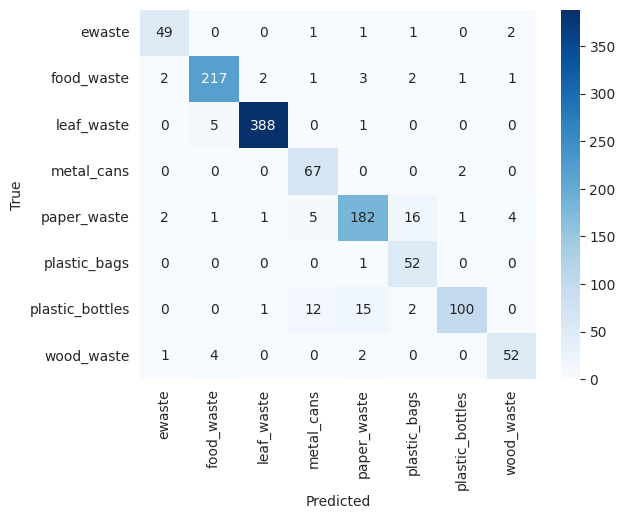

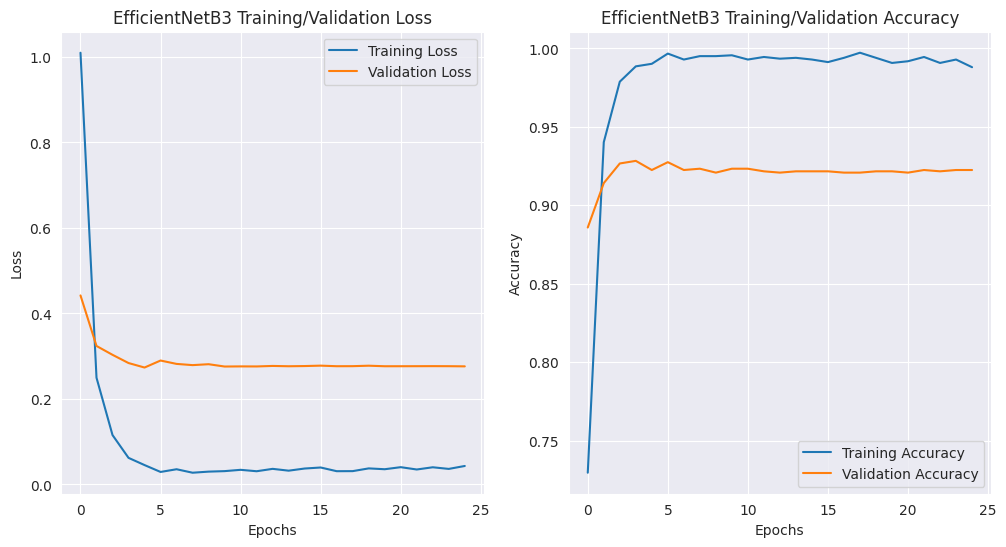

In [56]:
from itertools import product
# Iterate over all combinations
for learning_rate, epochs in product(learning_rates, epochs_list):
    print(f"\nTraining with learning rate for EfficientNetB3: {learning_rate}, epochs: {epochs}\n{'='*50}")

    # Create LR_ASK callback
    ask_epoch = 25  
    ask = LR_ASK(model, epochs, ask_epoch)
    callbacks = [ask]

    # Create and train ResNet50
    effnet_model, effnet_history = create_and_train_model(EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3)),
                                                          train_gen, valid_gen, epochs=epochs, learning_rate=learning_rate, callbacks=callbacks)
    # Plot training/validation loss and accuracy
    plot_training_history(effnet_history, 'EfficientNetB3')

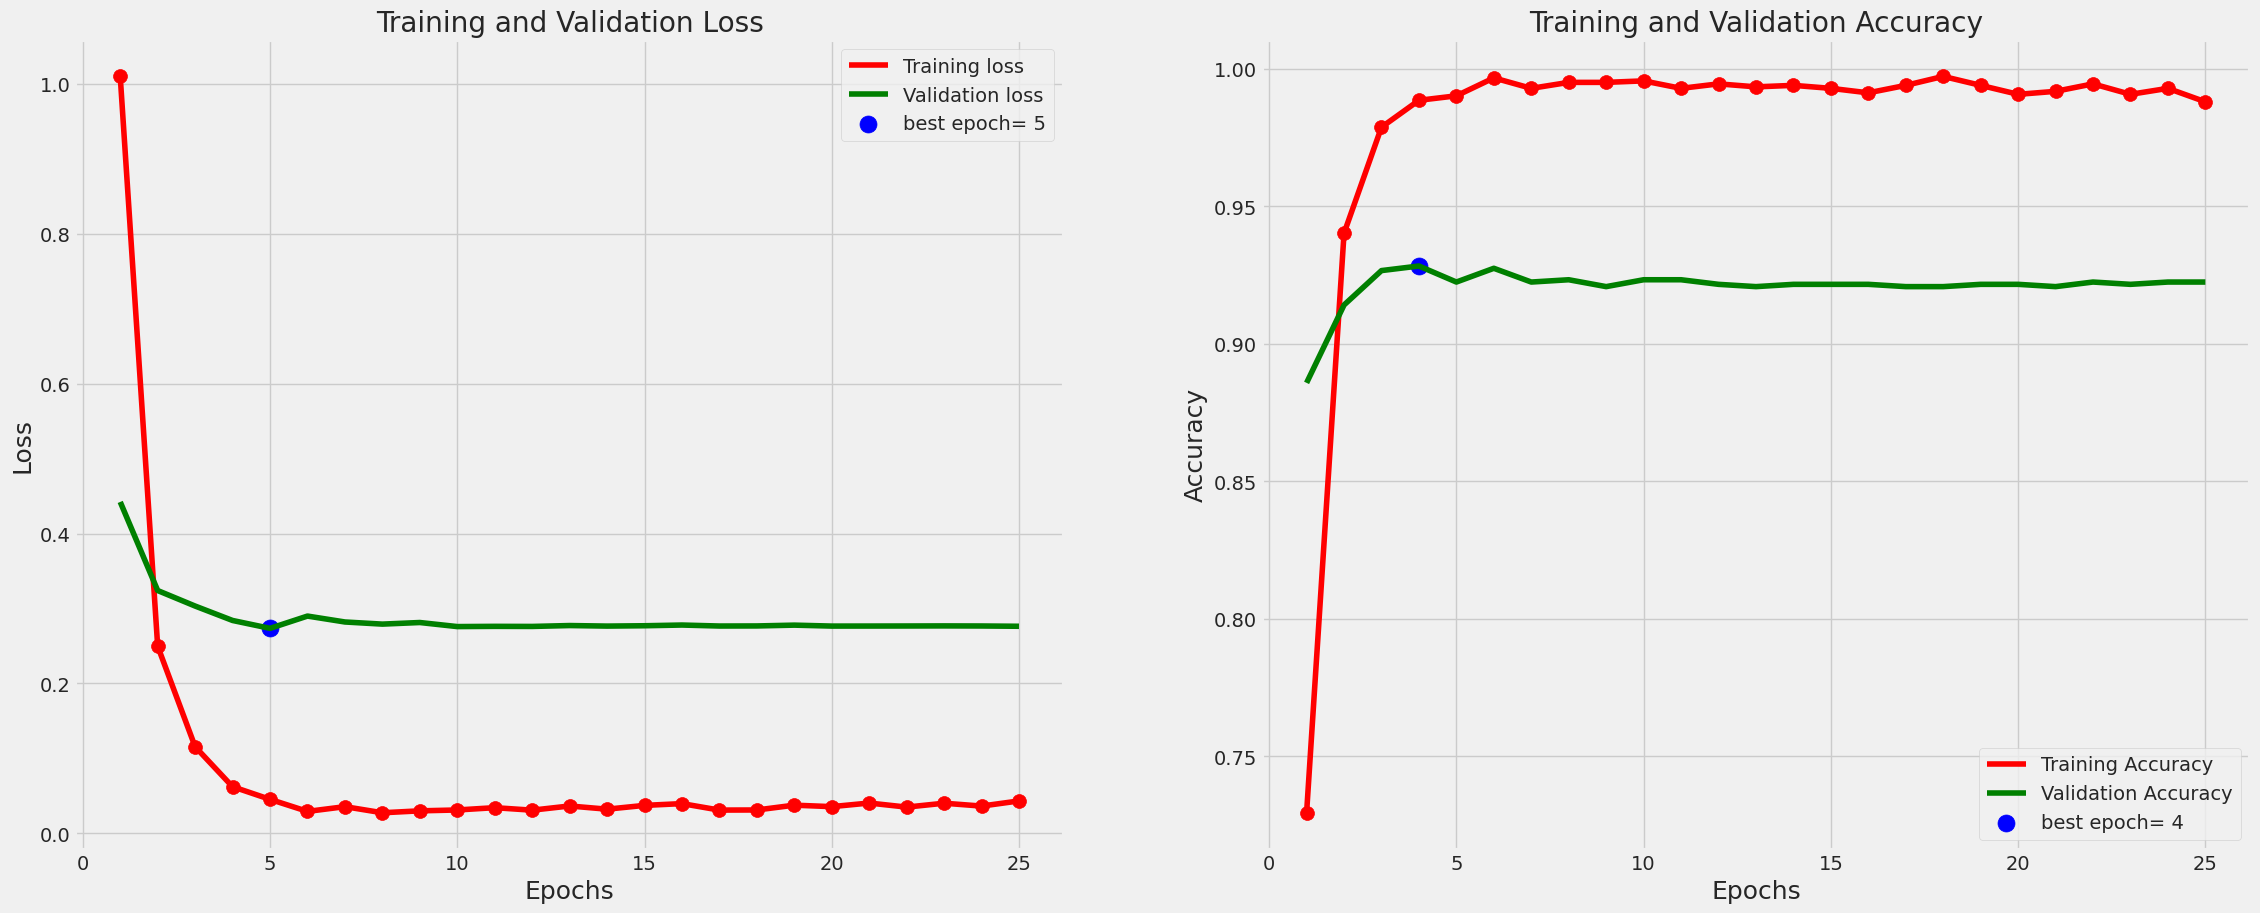

In [60]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(effnet_history,0)

# EfficientNet Model Try

In [64]:
epochs=40
ask_epoch=15
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [65]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr)
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B3 model with initial learning rate set to 0.001

Training will proceed until epoch 15 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40


2023-12-04 18:03:20.903243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 7.8997 - accuracy: 0.7947
 validation loss of  7.4927 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

62/62 [==============================] - 101s 627ms/step - loss: 7.8997 - accuracy: 0.7947 - val_loss: 7.4927 - val_accuracy: 0.8942
Epoch 2/40
62/62 [==============================] - ETA: 0s - loss: 6.0924 - accuracy: 0.9560
 validation loss of  5.8145 is 22.3975 % below lowest loss, saving weights from epoch 2   as best weights

62/62 [==============================] - 37s 588ms/step - loss: 6.0924 - accuracy: 0.9560 - val_loss: 5.8145 - val_accuracy: 0.9058
Epoch 3/40
62/62 [==============================] - ETA: 0s - loss: 5.0020 - accuracy: 0.9690
 validation loss of  4.7761 is 17.8595 % below lowest loss, saving weights from epoch 3   as best weights

62/62 [==============================] - 36s 583ms/step - loss: 5.0020 - accuracy: 0.9690 - val_loss: 4.7761 - val_accuracy: 0.9167
Epoch 4/40


 15


you entered 15 Training will continue to epoch 30

62/62 [==============================] - 46s 751ms/step - loss: 0.6310 - accuracy: 0.9978 - val_loss: 0.7965 - val_accuracy: 0.9267
Epoch 16/40
62/62 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.9967
 validation loss of  0.7169 is  9.9900 % below lowest loss, saving weights from epoch 16  as best weights

62/62 [==============================] - 36s 585ms/step - loss: 0.5554 - accuracy: 0.9967 - val_loss: 0.7169 - val_accuracy: 0.9233
Epoch 17/40
62/62 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.9967
 validation loss of  0.6553 is  8.5924 % below lowest loss, saving weights from epoch 17  as best weights

62/62 [==============================] - 36s 584ms/step - loss: 0.4815 - accuracy: 0.9967 - val_loss: 0.6553 - val_accuracy: 0.9267
Epoch 18/40
62/62 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.9978
 validation loss of  0.6154 is  6.0927 % below lowest 

 10


you entered 10 Training will continue to epoch 40

62/62 [==============================] - 43s 698ms/step - loss: 0.2531 - accuracy: 0.9995 - val_loss: 0.4681 - val_accuracy: 0.9275
Epoch 31/40
62/62 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9989
 validation loss of  0.4580 is  2.1475 % below lowest loss, saving weights from epoch 31  as best weights

62/62 [==============================] - 36s 582ms/step - loss: 0.2500 - accuracy: 0.9989 - val_loss: 0.4580 - val_accuracy: 0.9258
Epoch 32/40
62/62 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 1.0000
 validation loss of  0.4502 is  1.7219 % below lowest loss, saving weights from epoch 32  as best weights

62/62 [==============================] - 36s 582ms/step - loss: 0.2339 - accuracy: 1.0000 - val_loss: 0.4502 - val_accuracy: 0.9300
Epoch 33/40
62/62 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 1.0000
 validation loss of  0.4485 is  0.3724 % below lowest 

 h


you entered h,  Training halted on epoch 40 due to user input


62/62 [==============================] - 63s 1s/step - loss: 0.2148 - accuracy: 0.9995 - val_loss: 0.4298 - val_accuracy: 0.9275
loading model with weights from epoch 40

training elapsed time was 0.0 hours, 25.0 minutes, 57.76 seconds)



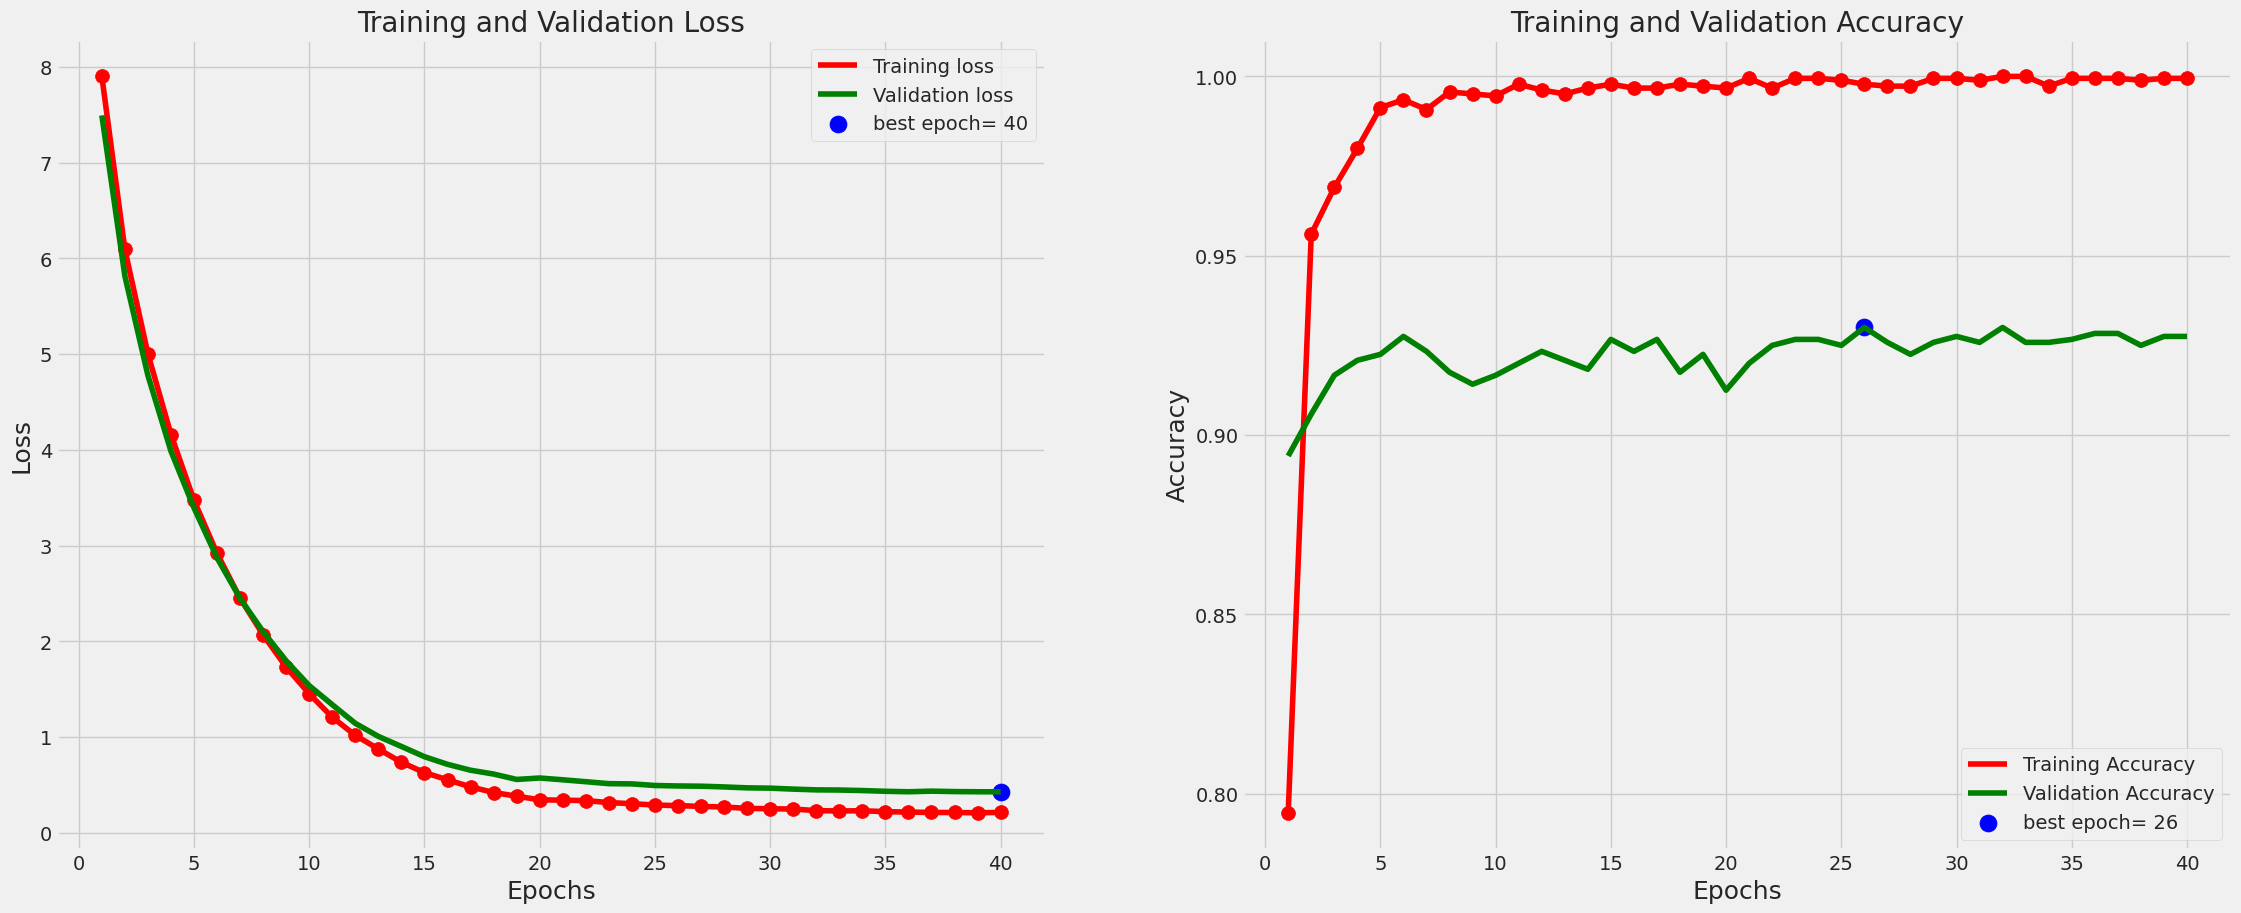

In [66]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

109/109 [==============================] - 11s 82ms/step
there were 26 errors in 1417 tests for an accuracy of  98.17



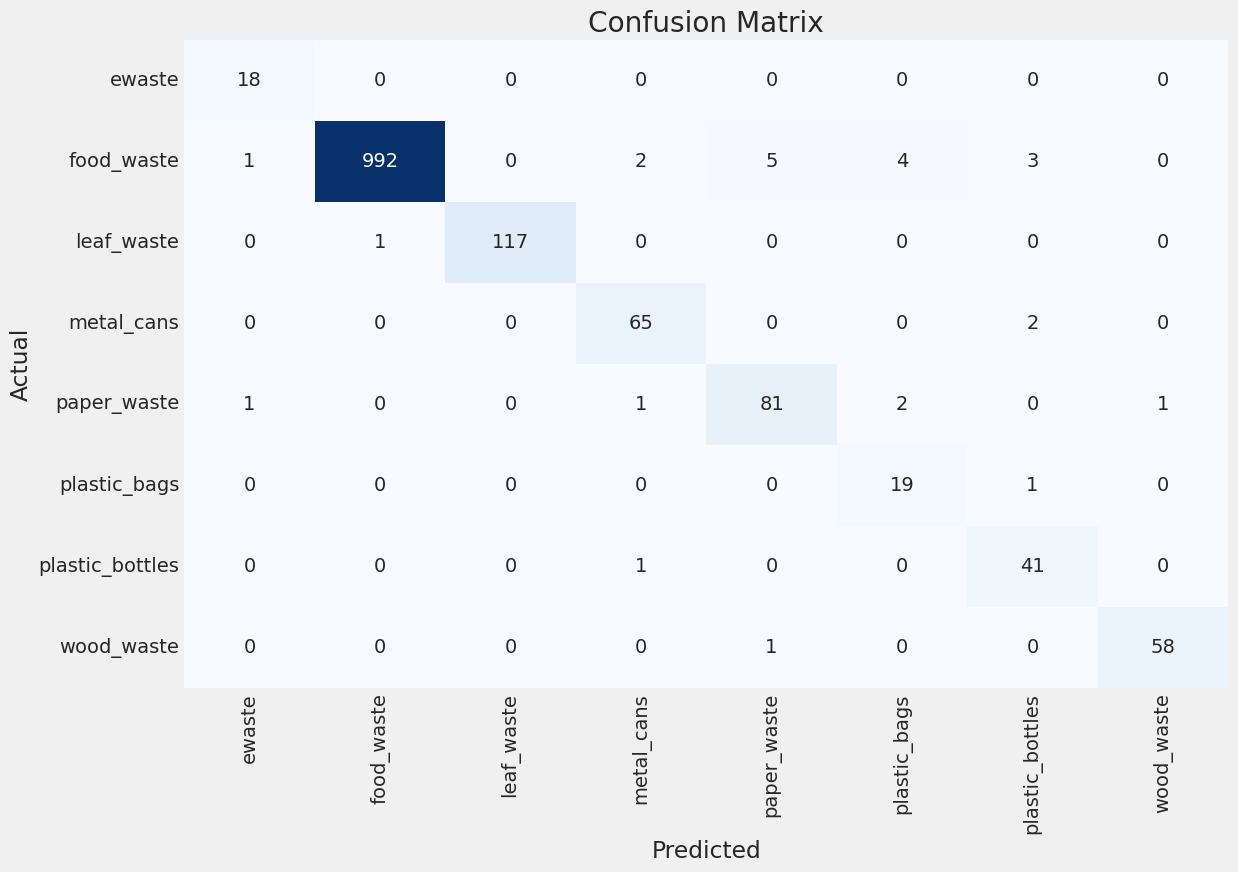

Classification Report:
----------------------
                  precision    recall  f1-score   support

         ewaste     0.9000    1.0000    0.9474        18
     food_waste     0.9990    0.9851    0.9920      1007
     leaf_waste     1.0000    0.9915    0.9957       118
     metal_cans     0.9420    0.9701    0.9559        67
    paper_waste     0.9310    0.9419    0.9364        86
   plastic_bags     0.7600    0.9500    0.8444        20
plastic_bottles     0.8723    0.9762    0.9213        42
     wood_waste     0.9831    0.9831    0.9831        59

       accuracy                         0.9817      1417
      macro avg     0.9234    0.9747    0.9470      1417
   weighted avg     0.9832    0.9817    0.9821      1417



In [67]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

# Below is a list of test files that were miss classified

In [69]:
if len(error_list) > 0 and len(error_list)<50:
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i]        
        split=fpath.split('/')        
        f= split[6]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
          food_waste                   plastic_bags         
          food_waste                   plastic_bags         
          food_waste                   paper_waste          
          food_waste                   paper_waste          
          food_waste                      ewaste            
          food_waste                 plastic_bottles        
          food_waste                   plastic_bags         
          food_waste                    wood_waste          
          food_waste                 plastic_bottles        
          food_waste                    metal_cans          
          food_waste                    metal_cans          
          food_waste                      ewaste            
          food_waste                   plastic_bags         
          food_waste                   paper_waste          
          food_waste       